In [1]:
import torch
import torchvision
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import numpy as np
import torch
import math
import umap.umap_ as umap
import os
import pickle
import pickle5
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import transforms
from pathlib import Path
import torch.nn.init as init
from torch.nn.parameter import Parameter
from torch.distributions.normal import Normal
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.multinomial import Multinomial
from torchvision.datasets import FashionMNIST, CIFAR100,ImageFolder
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torchvision import datasets, transforms
from tqdm import tqdm
import gc
from torch.utils.data import Dataset
import wandb
import time
from torch.utils.tensorboard import SummaryWriter
import pdb

2023-05-13 19:27:13.179609: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


#### Load imagenet 2012 data

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Set the root directory where the ImageNet dataset is stored
DATASET_DIR = '/D/datasets/imagenet/'

# transform = transforms.Compose([transforms.Resize((299, 299)),
#                                 transforms.ToTensor()])

transform = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the ImageNet dataset and select the first 100,000 samples
train_dataset = datasets.ImageNet(root=DATASET_DIR, split='train', transform=transform)
train_subset_dataset = torch.utils.data.Subset(train_dataset, range(100000))

val_dataset = datasets.ImageNet(root=DATASET_DIR, split='val', transform=transform)
val_subset_dataset = torch.utils.data.Subset(val_dataset, range(20000))

# Create a data loader to iterate over the subset dataset
# train_data_loader = torch.utils.data.DataLoader(train_subset_dataset, batch_size=32, shuffle=True)
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_data_loader = torch.utils.data.DataLoader(val_subset_dataset, batch_size=32, shuffle=True)
val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)

# TEST_DATASET_DIR = '/D/datasets/imagenet/test'
# test_dataset = ImageFolder(TEST_DATASET_DIR, transform=transform)
# test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

# for x, y in test_data_loader:
#     break
# plt.imshow(np.transpose(x[0], (1, 2, 0))
# print(y[0])

#### Load inception_v3 pretrained model
Inception v3 is a deep convolutional neural network architecture for image classification. It achieved a top-1 accuracy of 78.0% and a top-5 accuracy of 93.9% on the ImageNet dataset.

In [4]:
# Load the pretrained Inception V3 model
model = torchvision.models.inception_v3(pretrained=True)
_ = model.eval()

# Move the model to the GPU if available
_ = model.to(device)

#### Test inception v3 on test data - Sanity test

In [4]:
def test_model(model, test_data_loader):
    model.eval()
    total_correct = 0
    total_incorrect = 0
    with torch.no_grad():
        for x, y in tqdm(test_data_loader):
            output = model(x.to(device))
            if type(output) == tuple:
                logits = output[-1].squeeze(0)
            else:
                logits = output
            predictions = torch.argmax(torch.softmax(logits, dim=-1), dim=1)#.to(torch.device('cpu'))
            correct_classifications = sum(predictions == y.to(device))
            incorrect_classifications = len(x) - correct_classifications
            total_correct += correct_classifications
            total_incorrect += incorrect_classifications
    model.train()
    print(f"acc: {print(total_correct / (total_correct + total_incorrect))}")

#### Sanity check for model's accuracy
Expected acc: ~77.3%
We can only test on the validation set as the test set is unlabled

In [5]:
test_model(model, val_data_loader)

100%|███████████████████████████████████████| 1563/1563 [05:00<00:00,  5.21it/s]

tensor(0.7722, device='cuda:0')
acc: None


#### Replace last classifier layer with identity layer

In [6]:
# Replace the last layer with an identity layer
model.fc = torch.nn.Identity()

#### Create new dataloaders with embeddings

In [5]:
class LogitsDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]
        return x, y

In [6]:
def get_logits_dataloader(model, original_loader, batch_size=32, whiten=False):
    logits_data_list = []
    logits_labels_list = []
    with torch.no_grad():
        for x, y in tqdm(original_loader):
            logits = model(x.to(device))
            logits_data_list.append(logits.to(torch.device('cpu')))
            logits_labels_list.append(y.to(torch.device('cpu')))

    logits_data_set = LogitsDataset(torch.concat(logits_data_list), torch.concat(logits_labels_list))
    logits_dataloader = DataLoader(logits_data_set, batch_size=batch_size, shuffle=True)
    if whiten:
        # Apply whitening to the features
        scaler = StandardScaler()
        outputs = scaler.fit_transform(torch.concat(logits_data_list).numpy())
        pca = PCA()
        whitened = pca.fit_transform(outputs)

        whitened_logits_data_set = LogitsDataset(whitened, torch.concat(logits_labels_list))
        whitened_logits_dataloader = DataLoader(whitened_logits_data_set, batch_size=batch_size, shuffle=True)
        return whitened_logits_dataloader
    else:
        return logits_dataloader

In [8]:
logits_trian_dataloader = get_logits_dataloader(model, train_data_loader, batch_size=32, whiten=False)
logits_val_dataloader = get_logits_dataloader(model, val_data_loader, batch_size=32, whiten=False)

100%|███████████████████████████████████████| 1563/1563 [05:11<00:00,  5.01it/s]


In [7]:
LOGITS_TRAIN_DATALOADER_PATH = '/D/datasets/imagenet/logits_dataloaders/logits_trian_dataloader.pkl'
LOGITS_VAL_DATALOADER_PATH = '/D/datasets/imagenet/logits_dataloaders/logits_val_dataloader.pkl'

In [ ]:
# Save
# with open(LOGITS_TRAIN_DATALOADER_PATH, 'wb') as f:
#     pickle5.dump(logits_trian_dataloader, f)
# with open(LOGITS_VAL_DATALOADER_PATH, 'wb') as f:
#     pickle5.dump(logits_val_dataloader, f)
# print('Saved dataloaders!')

In [9]:
# Load
with open(LOGITS_TRAIN_DATALOADER_PATH, 'rb') as f:
    logits_trian_dataloader = pickle5.load(f)
with open(LOGITS_VAL_DATALOADER_PATH, 'rb') as f:
    logits_val_dataloader = pickle5.load(f)

##### Statistical functions
Note we assume a diagonal (and of course positive cov matrix $\Sigma$.
Where $D$ is the dimention size of a multivariate gaussian:
$$H(N_D(\mu,\Sigma))=\frac{D}{2}(1+log(2\pi))+\frac{1}{2}log|\Sigma|$$
<br>
$$H(X~multi)=\Sigma_{x}p(x)log(\frac{1}{x})$$
<br>
$$KL(N(\mu_1,\Sigma_1||N(\mu_2,\Sigma_2))=\frac{1}{2}[log\frac{|\Sigma_2|}{|\Sigma_1|}-D+tr\{\Sigma^{-1}_{2}\Sigma_1\}+(\mu_2-\mu_1)^T\Sigma^{-1}_{2}(\mu_2-\mu_1)]$$
<br>
* https://gregorygundersen.com/blog/2020/09/01/gaussian-entropy/#:~:text=Entropy%20of%20the%20multivariate%20Gaussian.&text=Again%2C%20we%20use%20the%20fact,a%20function%20of%20the%20covariance.
* https://stats.stackexchange.com/questions/60680/kl-divergence-between-two-multivariate-gaussians

In [20]:
EPSILON = 1e-20


def get_multivariate_gaussian_entropy(std, epsilon=EPSILON):
    """
    $$H(N_D(\mu,\Sigma))=\frac{D}{2}(1+log(2\pi))+\frac{1}{2}log|\Sigma|$$
    Assuming a diagonal cov matrix represented as a vector
    """
    std = std.to(torch.float64)
    if not (std > 0).all():
        raise ValueError('Got a non-positive entry in diagonal cov matrix')
    D = std.shape[-1]
    log_term = torch.log(torch.clamp(torch.prod(std, dim=-1), min=epsilon))
    return torch.maximum(epsilon, ((D / 2) * (1 + np.log(2 * np.pi)) + 0.5 * log_term)).mean()


def get_multinomial_entropy(logits, epsilon=EPSILON):
    """
    Receives unactivates logits
    epsilon replaces 0 probability that results from torch's low float resolution
    """
    logits = logits.squeeze(0).to(torch.float64)
    probs = torch.softmax(logits, dim=-1)
    probs = torch.clamp(probs, epsilon, 1 - epsilon)
    return (probs * torch.log(1/probs)).sum(dim=-1).mean()


def get_kld_between_multivariate_gaussians(mu1, mu2, std1, std2, epsilon=EPSILON):
    """
    assuming diagonal cov matrix as 1d ndarray
    """
    N, D = mu1.shape

    # Compute the log term
    log_term = torch.log(torch.clamp(torch.prod(
        std2, dim=-1) / torch.prod(std1, dim=-1), min=epsilon))

    # Compute the trace term
    trace_term = ((1 / std2) * std1).sum(dim=-1)

    # Compute the quadratic term
    mu_diff = mu2 - mu1
    quadratic_term = torch.sum((mu_diff * (1 / std2) * mu_diff), dim=-1)

    # Compute the KLD for each pair of Gaussians
    kld = 0.5 * (log_term - D + trace_term + quadratic_term)

    return kld


#### VIB classifier
Inputs are passed through two fully connected
layers, each with 1024 (2048) units. Next, data is fed to a stochastic encoding layer; this layer is characterized by a spherical Gaussian with 1024 (2048) learned means and standard deviations. The output of
the stochastic layer is fed to the variational classifier–itself a logistic regression

In [11]:
def reparametrize(mu, std, device):
    """
    Performs reparameterization trick z = mu + epsilon * std
    Where epsilon~N(0,1)
    """
    mu = mu.expand(1, *mu.size())
    std = std.expand(1, *std.size())
    eps = torch.normal(0, 1, size=std.size()).to(device)
    return mu + eps * std

class VIB(nn.Module):
    """
    Classifier with stochastic layer and KL regularization
    """
    def __init__(self, hidden_size, device):
        super(VIB, self).__init__()
        self.device = device
        self.description = 'Vanilla IB VAE as per the paper'
        self.hidden_size = hidden_size
        self.k = hidden_size // 2
        self.train_loss = []
        self.test_loss = []

        self.encoder = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        )
        self.classifier = nn.Linear(self.k, 1000)

        # Xavier initialization
        for _, module in self._modules.items():
            if isinstance(module, nn.Linear) or isinstance(module, nn.Conv2d):
                        nn.init.xavier_uniform_(module.weight, gain=nn.init.calculate_gain('relu'))
                        module.bias.data.zero_()
                        continue
            for layer in module:
                if isinstance(layer, nn.Linear) or isinstance(layer, nn.Conv2d):
                            nn.init.xavier_uniform_(layer.weight, gain=nn.init.calculate_gain('relu'))
                            layer.bias.data.zero_()
        
    def forward(self, x):
        z_params = self.encoder(x)
        mu = z_params[:, :self.k]
        # softplus transformation (soft relu) and a -5 bias is added as in the paper
        std = F.softplus(z_params[:, self.k:] - 5, beta=1)
        if self.training:
            z = reparametrize(mu, std, self.device)
        else:
            z = mu.clone().unsqueeze(0)
        n = Normal(mu, std)
        log_probs = n.log_prob(z.squeeze(0))  # These may be positive as this is a PDF
        
        logits = self.classifier(z)
        return (mu, std), log_probs, logits
   
def vib_loss(logits, labels, mu, std, beta):
    classification_loss = nn.CrossEntropyLoss()(logits.squeeze(0), labels)  # In torch cross entropy function applies the softmax itself
    normalization_loss = -0.5 * (1 + 2 * std.log() - mu.pow(2) - std.pow(2)).sum()
    # KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))
    return classification_loss + beta * normalization_loss


In [21]:
def loop_data(model, train_dataloader, test_dataloader, beta, model_save_path, epochs,
              device, optimizer=None, scheduler=None, eta=0.001,
              num_minibatches=1, is_ppo=False, run_name="test_run", is_dyn_beta=False, is_new_loss=False):
    wandb.init(
        project='dynamic_beta',
        entity=None,
        sync_tensorboard=True,
        config=None,
        name=run_name,
        monitor_gym=False,
        save_code=True,)
    writer = SummaryWriter(f"runs/{run_name}")

    model.train()

    epoch_i_z_x_array = np.zeros(epochs)
    epoch_i_z_y_array = np.zeros(epochs)

    for e in tqdm(range(epochs)):
        epoch_loss = 0
        epoch_classification_loss = 0
        epoch_total_kld = 0
        epoch_ratio1 = 0
        epoch_ratio2 = 0
        epoch_ratio3 = 0
        epoch_ratio4 = 0
        epoch_mean_y_entropy = 0
        epoch_mean_z_entropy = 0

        if is_dyn_beta:
            if e < 2:
                beta = EPSILON
            else:
                with torch.no_grad():
                    epoch_i_z_x_delta = epoch_i_z_x_array[e - 1] - epoch_i_z_x_array[e - 2]
                    epoch_i_z_y_delta = epoch_i_z_y_array[e - 1] - epoch_i_z_y_array[e - 2] 
                    beta = epoch_i_z_y_delta / epoch_i_z_x_delta
                    if (epoch_i_z_x_delta == 0) or (beta > 1):
                        beta = EPSILON

        for batch_num, (embeddings, labels) in enumerate(train_dataloader):
            # Compute base z distribution
            with torch.no_grad():
                x = embeddings.to(device)
                (base_mu, base_std), base_log_probs, _ = model(x)

            for i in range(num_minibatches):
                x = embeddings.to(device)
                y = labels.to(device)
                (mu, std), log_probs, logits = model(x)
#                 activated = torch.softmax(logits, -1)

                batch_h_z_x = get_multivariate_gaussian_entropy(std)
                batch_h_z_y = get_multinomial_entropy(logits)

                with torch.no_grad():
                    epoch_i_z_x_array[e] += batch_h_z_x / len(train_dataloader)
                    epoch_i_z_y_array[e] += batch_h_z_y / len(train_dataloader)

                kld_from_std_normal = (-0.5 * (1 + 2 * std.log() -
                                       mu.pow(2) - std.pow(2))).sum(1).mean(0, True)
                log_ratio = log_probs - base_log_probs

                if is_ppo:
                    with torch.no_grad():
                        #                         kld_from_base_dist_old = torch.distributions.kl_divergence(
                        #                             Normal(base_mu, base_std), Normal(mu, std)).sum(1).mean(0, True)
                        #                         kld_from_base_dist = torch.distributions.kl_divergence(
                        #                             Normal(mu, std), Normal(base_mu, base_std)).sum(1).mean(0, True)
                        kld_from_base_dist = get_kld_between_multivariate_gaussians(
                            base_mu, base_std, mu, std)

                classification_loss = nn.CrossEntropyLoss()(logits.squeeze(0), y)

                if is_ppo:
                    # Replacing Beta
                    ratio = kld_from_base_dist / \
                        (kld_from_std_normal + kld_from_base_dist)
                    minibatch_loss = classification_loss + \
                        (beta * ratio).mean() * kld_from_std_normal.sum()
                elif is_new_loss:
                    minibatch_loss = -batch_h_z_x + beta * (classification_loss + batch_h_z_y)
                else:
                    minibatch_loss = classification_loss + beta * kld_from_std_normal

                optimizer.zero_grad()
                minibatch_loss.backward()
                optimizer.step()

                with torch.no_grad():
                    epoch_total_kld += kld_from_std_normal / num_minibatches
                    epoch_classification_loss += classification_loss.item() / num_minibatches
                    if is_ppo:
                        if i == 0:
                            epoch_ratio1 += ratio
                        elif i == 1:
                            epoch_ratio2 += ratio
                        elif i == 2:
                            epoch_ratio3 += ratio
                        elif i == 3:
                            epoch_ratio4 += ratio

            epoch_loss += minibatch_loss.item()

        epoch_loss /= batch_num
        model.train_loss.append(epoch_loss)
        writer.add_scalar("charts/epoch_train_loss", epoch_loss, e)
        writer.add_scalar(
            "charts/epoch_classification_loss", epoch_classification_loss / len(train_dataloader), e)
        writer.add_scalar(
            "charts/epoch_total_kld", epoch_total_kld / len(train_dataloader), e)

        if is_dyn_beta:
            writer.add_scalar("charts/epoch_i_z_x", epoch_i_z_x_array[e], e)
            writer.add_scalar("charts/epoch_i_z_y", epoch_i_z_y_array[e], e)
            writer.add_scalar("charts/epoch_dyn_beta", beta, e)

        if is_ppo:
            writer.add_scalar(
                "charts/epoch_ratio1", epoch_ratio1 / len(train_dataloader), e)
            writer.add_scalar(
                "charts/epoch_ratio2", epoch_ratio2 / len(train_dataloader), e)
            writer.add_scalar(
                "charts/epoch_ratio3", epoch_ratio3 / len(train_dataloader), e)
            writer.add_scalar(
                "charts/epoch_ratio4", epoch_ratio4 / len(train_dataloader), e)
            writer.add_scalar(
                "charts/avg_epoch_ratio", (epoch_ratio1 + epoch_ratio2 +
                                           epoch_ratio3 + epoch_ratio4) / (len(train_dataloader) * 4), e)
            writer.add_scalar(
                "charts/total_epoch_ratio", (epoch_ratio1 + epoch_ratio2 + epoch_ratio3 + epoch_ratio4) / len(train_dataloader), e)

        # test loss
        model.eval()
        epoch_test_loss = 0
        for batch_num, (embeddings, labels) in enumerate(test_dataloader):
            x = embeddings.to(device)
            y = labels.to(device)
            (mu, std), log_probs, logits = model(x)
            epoch_test_loss += vib_loss(logits, y, mu, std, beta).item()
            # TODO: add this line
            # epoch_test_loss += vib_loss(logits, y, mu, std, beta).item() / len(train_dataloader)
        model.test_loss.append(epoch_test_loss)
        writer.add_scalar("charts/epoch_val_loss", epoch_test_loss, e)
        model.train()



##### New dynamic beta $\frac{I(;Y)}{I(Z;X}$

In [51]:
LR = 1e-4
EPOCHS = 70
BETA = 1
NUM_MINIBATCHES = 1

run_name = f"vib_imagenet_beta_new_dyn_beta_time_{int(time.time())}"

new_dyn_imagenet_vib_classifier = VIB(2048, device).to(device)
optimizer = optim.Adam(new_dyn_imagenet_vib_classifier.parameters(), LR / NUM_MINIBATCHES, betas=(0.5,0.999))
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.97)

loop_data(new_dyn_imagenet_vib_classifier, logits_trian_dataloader, logits_val_dataloader, BETA,
          num_minibatches=NUM_MINIBATCHES, model_save_path='/tmp', epochs=EPOCHS, device=device,
          optimizer=optimizer, scheduler=scheduler, is_ppo=False, run_name=run_name, is_dyn_beta=True)

charts/epoch_classification_loss,█▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
charts/epoch_dyn_beta,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
charts/epoch_i_z_x,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
charts/epoch_i_z_y,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
charts/epoch_total_kld,▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
charts/epoch_train_loss,█▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
charts/epoch_val_loss,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇█▇█
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
charts/epoch_classification_loss,0.07507
charts/epoch_dyn_beta,0.0
charts/epoch_i_z_x,0.0


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`
100%|████████████████████████████████████████| 70/70 [5:39:04<00:00, 290.64s/it]


In [ ]:
with open(f'/D/models/{run_name}.pkl', 'wb') as f:
    pickle.dump(new_dyn_imagenet_vib_classifier, f)
print(f'Saved model to /D/models/{run_name}.pkl')

In [13]:
with open(f'/D/models/test_new_beta.pkl', 'rb') as f:
    m = pickle5.load(f)

In [ ]:
test_model(new_dyn_imagenet_vib_classifier, logits_val_dataloader)

##### Train and eval over imagenet: Train, Test  for $\beta=0.01$

In [58]:
LR = 1e-4
EPOCHS = 70
BETA = 1e-2
NUM_MINIBATCHES = 1

run_name = f"vib_imagenet_beta0.01_new_logits_200epochs_time_{int(time.time())}"

constant_vib_classifier = VIB(2048, device).to(device)
optimizer = optim.Adam(constant_vib_classifier.parameters(), LR / NUM_MINIBATCHES, betas=(0.5,0.999))
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.97)

loop_data(constant_vib_classifier, logits_trian_dataloader, logits_val_dataloader, BETA,
          num_minibatches=NUM_MINIBATCHES, model_save_path='/tmp', epochs=EPOCHS, device=device,
          optimizer=optimizer, scheduler=scheduler, is_ppo=False, run_name=run_name)

charts/avg_epoch_ratio,▆▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▇█
charts/epoch_classification_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
charts/epoch_ratio1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
charts/epoch_ratio2,▂▁▁▂▂▂▂▂▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▆▆▇█
charts/epoch_ratio3,▅▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▆▆▇█
charts/epoch_ratio4,█▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▆▆▇
charts/epoch_total_kld,█▆▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
charts/epoch_train_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▃▃▃▄
charts/epoch_val_loss,█▇▆▆▆▆▆▅▅▅▅▅▄▃▄▄▅▃▄▅▄▄▄▄▅▃▅▃▃▂▃▃▁▃▃▃▄▁▂▄
charts/total_epoch_ratio,▆▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▇█
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`
100%|████████████████████████████████████████| 70/70 [4:36:36<00:00, 237.09s/it]


In [60]:
with open(f'/D/models/{run_name}.pkl', 'wb') as f:
    pickle.dump(constant_vib_classifier, f)
print(f'Saved model to /D/models/{run_name}.pkl')

Saved model to /D/models/vib_imagenet_beta0.01_new_logits_200epochs_time_1682845615.pkl


In [62]:
test_model(constant_vib_classifier, logits_val_dataloader)

100%|█████████████████████████████████████| 1563/1563 [00:01<00:00, 1308.86it/s]

tensor(0.7335, device='cuda:0')
acc: None


#### Train and eval over imagenet dynamic $\beta$

In [54]:
LR = 1e-4
EPOCHS = 200
BETA = 1e-3
NUM_MINIBATCHES = 4

run_name = f"vib_imagenet_dynamic_beta_new_logits_200epochs_time_{int(time.time())}"

vib_classifier = VIB(2048, device).to(device)
optimizer = optim.Adam(vib_classifier.parameters(), LR / NUM_MINIBATCHES, betas=(0.5,0.999))
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.97)

loop_data(vib_classifier, logits_trian_dataloader, logits_val_dataloader, BETA,
          num_minibatches=NUM_MINIBATCHES, model_save_path='/tmp', epochs=EPOCHS, device=device,
          optimizer=optimizer, scheduler=scheduler, is_ppo=True, run_name=run_name)

charts/epoch_classification_loss,▁
charts/epoch_total_kld,▁
charts/epoch_train_loss,▁
charts/epoch_val_loss,▁
global_step,▁
charts/epoch_classification_loss,1.09632
charts/epoch_total_kld,129.23921
charts/epoch_train_loss,2.38878
charts/epoch_val_loss,35782.64844
global_step,0


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`
 35%|████████████▎                      | 70/200 [17:17:36<32:06:58, 889.37s/it]


KeyboardInterrupt: 

In [55]:
with open(f'/D/models/{run_name}.pkl', 'wb') as f:
    pickle.dump(vib_classifier, f)
print(f'/D/models/{run_name}.pkl')

In [63]:
test_model(vib_classifier, logits_val_dataloader)

100%|█████████████████████████████████████| 1563/1563 [00:01<00:00, 1310.36it/s]

tensor(0.7422, device='cuda:0')
acc: None


#### Create adverserial test set
The Fast Gradient Sign (FGS) method proposed in Goodfellow et al. (2015) and the L2 optimization method proposed in Carlini & Wagner (2016). FGS is a standard baseline attack that takes a single step in the gradient direction to generate the adversarial example. As originally described, FGS generates untargeted adversarial examples. On MNIST, Goodfellow et al. (2015) reported that FGS could generate adversarial examples that fooled a maxout network approximately 90% of the time with  = 0.25, where  is the magnitude of the perturbation at each pixel. The L2 optimization method has been shown to generate adversarial examples with smaller perturbations than any other method published to date, which were capable of fooling the target network 100% of the time. We consider both targeted attacks and untargeted attacks for the L2 optimization method. <br>

Original image $\rightarrow x$ <br>
Petrubation = $\rightarrow r$ <br>
Adverserial example $\rightarrow x'=x+r$ <br>
True label $\rightarrow l$ <br>
Target label $\rightarrow l'$ <br>
We minimize the $L_2$ distance between $x$ and $x'$:
$$\underset{x'}{min}||x'-x||$$
$$s.t.$$
$$f(x)=l, f(x')=l', l\ne l'$$

*FGS - Fast Gradient Sign*

for each image do:
    run through net
    compute the sign gradient for that image $s\leftarrowsign(\grad_x(\theta,x,y))$
    

#### Load saved models

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [24]:
with open('/D/models/vib_imagenet_beta0.01_new_logits_200epochs_time_1682845615.pkl', 'rb') as f:
    model_beta_001 = pickle.load(f)
    
with open('/D/models/vib_imagenet_dynamic_beta_new_logits_200epochs_time_1682783102.pkl', 'rb') as f:
    model_beta_dyn = pickle.load(f)
    

#### Attack code

In [34]:
def fgsm_attack(data, epsilon, data_grad, is_targeted=False, is_image=True):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    if is_targeted:
        sign_data_grad *= -1
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_data = data + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    if is_image:
        perturbed_data = torch.clamp(perturbed_data, 0, 1)
    # Return the perturbed image
    return perturbed_data

In [35]:
def run_adverserial_attacks(model, device, test_loader, epsilon, target_label=None, is_image=True):

    # Accuracy counter
    correct = 0
    relevant_pertrubations = 0
    total_succesful_attacks = 0
    adv_examples = []

    model.eval()
    
    # Loop over all examples in test set
    for data, labels in test_loader:
        # Send the data and label to the device
        data, labels = data.to(device), labels.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        if type(output) == tuple:
            _, _, output = model(data)
        
#         if type(model) == torchvision.models.inception.Inception3:
#             output = model(data)
#         elif type(model) == MNIST_CNN:
#             output = model(data)
#         else:
#             _, _, output = model(data) # (mu, std), log_probs, logits
#         init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        init_pred = output.squeeze(0).max(dim=-1, keepdim=True)[1] # get the index of the max log-probability
        
        hit_vector = init_pred.squeeze(1) == labels
#         relevant_targeted_attack_vector = init_pred.squeeze(1) != target_label
        relevant_targeted_attack_vector = labels != target_label
        if target_label:
            relevant_attack_idx = torch.nonzero(relevant_targeted_attack_vector & (init_pred.squeeze(1) != target_label)).flatten()
        else:
            relevant_attack_idx = torch.nonzero(hit_vector).flatten()        
        
        # If the initial prediction is wrong, don't bother attacking, just move on
#         if init_pred.item() != labels.item():
        if len(relevant_attack_idx) == 0:
            correct += hit_vector.sum().to(torch.device('cpu'))
            continue
    
        relevant_output = output.squeeze(0)[relevant_attack_idx]
        relevant_labels = labels[relevant_attack_idx]

        # Calculate the loss for the gradient
        if target_label:
            # Targeted attack
#             loss = F.nll_loss(relevant_output, torch.tensor([target_label]).to(device))
            loss = F.nll_loss(relevant_output, torch.tensor(target_label).expand(relevant_output.shape[0]).to(device))
        else:
            # Untargeted attack
            loss = F.nll_loss(relevant_output, relevant_labels)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()
       
        # Collect ``datagrad``
        data_grad = data.grad[relevant_attack_idx].data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data[relevant_attack_idx], epsilon, data_grad, is_targeted=bool(target_label), is_image=is_image)
        
#         if (epsilon == 0) and not torch.all(perturbed_data == data[relevant_attack_idx]).item():
#             pdb.set_trace()
        
        # Re-classify the perturbed image
        perturbed_output = model(perturbed_data)
        if type(perturbed_output) == tuple:
            perturbed_output = perturbed_output[-1]
            
#         if type(model) == torchvision.models.inception.Inception3:
#             perturbed_output = model(perturbed_data)
#         elif type(model) == MNIST_CNN:
#             perturbed_output = model(perturbed_data)
#         else:
#             _, _, perturbed_output = model(perturbed_data)  # (mu, std), log_probs, logits
        
        relevant_pertrubations += perturbed_output.squeeze(0).shape[0]

        # Check for success
#         perturbed_pred = perturbed_output.max(1, keepdim=True)[1] # get the index of the max log-probability
        
        perturbed_pred = perturbed_output.squeeze(0).max(dim=-1, keepdim=True)[1] # get the index of the max log-probability
        
        correct_perturbed_classifications = perturbed_pred.flatten() == labels[relevant_attack_idx]
        
#         if (epsilon == 0) and not torch.all(correct_perturbed_classifications).item():
#             pdb.set_trace()
        
        # Unsuccessful attack
        if target_label:
            unsuccessful_attack_vector = perturbed_pred.flatten() != target_label
        else:
            unsuccessful_attack_vector = correct_perturbed_classifications
        
        num_unsuccessful_attacks = unsuccessful_attack_vector.sum()
        successful_attack_idx = torch.nonzero(~unsuccessful_attack_vector.flatten())
        num_successful_attacks = (~unsuccessful_attack_vector).sum()
        unsuccessful_attack_idx = torch.nonzero(unsuccessful_attack_vector.flatten())

        total_succesful_attacks += num_successful_attacks        
        
        # Diff between unsuccessful attack and correct classification
        # In correct classification we also take into account unrelevant items and those who didn't reach the required target
#         correct_batch_classifications = (~relevant_targeted_attack_vector & hit_vector).sum() + correct_perturbed_classifications.sum()
        correct_batch_classifications = correct_perturbed_classifications.sum()

        correct += correct_batch_classifications.to(torch.device('cpu'))
        # Special case for saving 0 epsilon examples
        if (epsilon == 0) and (len(adv_examples) < 5):
            adv_ex = perturbed_data[unsuccessful_attack_idx][0].squeeze().detach().cpu().numpy()
            adv_examples.append( (init_pred[unsuccessful_attack_idx][0].item(), perturbed_pred[unsuccessful_attack_idx][0].item(), adv_ex) )

        if num_successful_attacks and (epsilon != 0):
            # Save some adv examples for visualization later
#             if (len(adv_examples) < 5) and (not bool(target_label) or (target_label != labels.item())):
            if (len(adv_examples) < 5):
                adv_ex = perturbed_data[successful_attack_idx][0].squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred[successful_attack_idx][0].item(), perturbed_pred[successful_attack_idx][0].item(), adv_ex) )
        
    # Calculate final accuracy for this epsilon
    final_acc = correct / relevant_pertrubations # float(len(test_loader) * test_loader.batch_size)
    succesful_attack_rate = total_succesful_attacks.item() / relevant_pertrubations  # float(len(test_loader) * test_loader.batch_size)
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}\t %succesful attacks: {}\t Out of total of {} data points".format(epsilon, correct, relevant_pertrubations, final_acc, succesful_attack_rate, len(test_loader) * test_loader.batch_size))

    # Return the accuracy and an adversarial example
    return final_acc, succesful_attack_rate, adv_examples


**Uargeted attacks**

In [31]:
EPSILONS = [0, .05, .1, .15, .2, .25, .3]

Original model

In [35]:
accuracies = []
examples = []
total_succesful_attacks_list = []

# for model in [model_beta_001, model_beta_dyn]

# Run test for each epsilon
for eps in tqdm(EPSILONS):
    acc, total_succesful_attacks, ex = run_adverserial_attacks(model, device, val_data_loader, eps, is_image=False)#, target_label=805)
    accuracies.append(acc)
    total_succesful_attacks_list.append(total_succesful_attacks)    
    examples.append(ex)

 14%|██████                                    | 1/7 [10:10<1:01:00, 610.15s/it]

Epsilon: 0	Test Accuracy = 38610 / 38612 = 0.9999482035636902	 %succesful attacks: 5.179736869367036e-05	 Out of total of 50016 data points


 29%|████████████▌                               | 2/7 [20:27<51:13, 614.64s/it]

Epsilon: 0.05	Test Accuracy = 12616 / 38612 = 0.32673779129981995	 %succesful attacks: 0.6732621982803274	 Out of total of 50016 data points


 43%|██████████████████▊                         | 3/7 [30:53<41:19, 619.81s/it]

Epsilon: 0.1	Test Accuracy = 11980 / 38612 = 0.3102662265300751	 %succesful attacks: 0.6897337615249145	 Out of total of 50016 data points


 57%|█████████████████████████▏                  | 4/7 [41:24<31:12, 624.25s/it]

Epsilon: 0.15	Test Accuracy = 12106 / 38612 = 0.31352946162223816	 %succesful attacks: 0.6864705272972133	 Out of total of 50016 data points


 71%|███████████████████████████████▍            | 5/7 [51:58<20:55, 627.51s/it]

Epsilon: 0.2	Test Accuracy = 12344 / 38612 = 0.31969335675239563	 %succesful attacks: 0.6803066404226665	 Out of total of 50016 data points


 86%|████████████████████████████████████      | 6/7 [1:02:32<10:29, 629.89s/it]

Epsilon: 0.25	Test Accuracy = 12658 / 38612 = 0.32782554626464844	 %succesful attacks: 0.6721744535377603	 Out of total of 50016 data points


100%|██████████████████████████████████████████| 7/7 [1:13:07<00:00, 626.80s/it]

Epsilon: 0.3	Test Accuracy = 12785 / 38612 = 0.33111467957496643	 %succesful attacks: 0.6688853206257123	 Out of total of 50016 data points


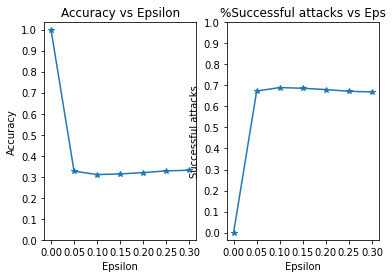

In [36]:
fig, ax = plt.subplots(1, 2)
_ = ax[0].plot(EPSILONS, accuracies, "*-")
_ = ax[0].set_yticks(np.arange(0, 1.1, step=0.1))
_ = ax[0].set_xticks(np.arange(0, .35, step=0.05))
_ = ax[0].set_title("Accuracy vs Epsilon")
_ = ax[0].set_xlabel("Epsilon")
_ = ax[0].set_ylabel("Accuracy")

_ = ax[1].plot(EPSILONS, total_succesful_attacks_list, "*-")
_ = ax[1].set_yticks(np.arange(0, 1.1, step=0.1))
_ = ax[1].set_xticks(np.arange(0, .35, step=0.05))
_ = ax[1].set_title("%Successful attacks vs Eps")
_ = ax[1].set_xlabel("Epsilon")
_ = ax[1].set_ylabel("Successful attacks")


In [ ]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(EPSILONS)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(EPSILONS),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(EPSILONS[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        normalized_ex = np.transpose( (ex - ex.min()) / (ex.max() - ex.min()) , (1, 2, 0))
        plt.imshow(normalized_ex)
plt.tight_layout()
plt.show()

Constant beta

In [34]:
accuracies = []
examples = []
total_succesful_attacks_list = []

# for model in [model_beta_001, model_beta_dyn]

# Run test for each epsilon
for eps in tqdm(EPSILONS):
    acc, total_succesful_attacks, ex = run_adverserial_attacks(model_beta_001, device, logits_val_dataloader, eps, is_image=False)#, target_label=805)
    accuracies.append(acc)
    total_succesful_attacks_list.append(total_succesful_attacks)    
    examples.append(ex)

 14%|██████▍                                      | 1/7 [00:03<00:20,  3.38s/it]

Epsilon: 0	Test Accuracy = 36674 / 36674 = 1.0	 Out of total of 50016 data points


 29%|████████████▊                                | 2/7 [00:06<00:16,  3.29s/it]

Epsilon: 0.05	Test Accuracy = 5709 / 36674 = 0.15566886961460114	 Out of total of 50016 data points


 43%|███████████████████▎                         | 3/7 [00:09<00:13,  3.26s/it]

Epsilon: 0.1	Test Accuracy = 552 / 36674 = 0.015051535330712795	 Out of total of 50016 data points


 57%|█████████████████████████▋                   | 4/7 [00:13<00:09,  3.25s/it]

Epsilon: 0.15	Test Accuracy = 250 / 36674 = 0.006816818378865719	 Out of total of 50016 data points


 71%|████████████████████████████████▏            | 5/7 [00:16<00:06,  3.24s/it]

Epsilon: 0.2	Test Accuracy = 145 / 36674 = 0.003953754901885986	 Out of total of 50016 data points


 86%|██████████████████████████████████████▌      | 6/7 [00:19<00:03,  3.23s/it]

Epsilon: 0.25	Test Accuracy = 94 / 36674 = 0.0025631238240748644	 Out of total of 50016 data points


100%|█████████████████████████████████████████████| 7/7 [00:22<00:00,  3.25s/it]

Epsilon: 0.3	Test Accuracy = 69 / 36674 = 0.0018814419163390994	 Out of total of 50016 data points


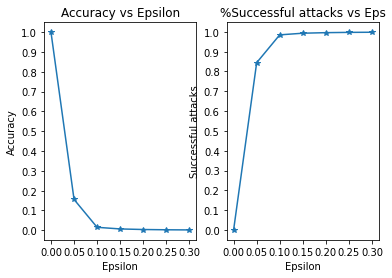

In [36]:
fig, ax = plt.subplots(1, 2)
_ = ax[0].plot(EPSILONS, accuracies, "*-")
_ = ax[0].set_yticks(np.arange(0, 1.1, step=0.1))
_ = ax[0].set_xticks(np.arange(0, .35, step=0.05))
_ = ax[0].set_title("Accuracy vs Epsilon")
_ = ax[0].set_xlabel("Epsilon")
_ = ax[0].set_ylabel("Accuracy")

_ = ax[1].plot(EPSILONS, total_succesful_attacks_list, "*-")
_ = ax[1].set_yticks(np.arange(0, 1.1, step=0.1))
_ = ax[1].set_xticks(np.arange(0, .35, step=0.05))
_ = ax[1].set_title("%Successful attacks vs Eps")
_ = ax[1].set_xlabel("Epsilon")
_ = ax[1].set_ylabel("Successful attacks")


Dynamic beta

In [34]:
accuracies = []
examples = []
total_succesful_attacks_list = []

# for model in [model_beta_001, model_beta_dyn]

# Run test for each epsilon
for eps in tqdm(EPSILONS):
    acc, total_succesful_attacks, ex = run_adverserial_attacks(model_beta_dyn, device, logits_val_dataloader, eps, is_image=False)#, target_label=805)
    accuracies.append(acc)
    total_succesful_attacks_list.append(total_succesful_attacks)    
    examples.append(ex)

 14%|██████▍                                      | 1/7 [00:03<00:19,  3.32s/it]

Epsilon: 0	Test Accuracy = 37112 / 37112 = 1.0	 %succesful attacks: 0.0	 Out of total of 50016 data points


 29%|████████████▊                                | 2/7 [00:06<00:16,  3.31s/it]

Epsilon: 0.05	Test Accuracy = 34342 / 37112 = 0.9253610968589783	 %succesful attacks: 0.0746389308040526	 Out of total of 50016 data points


 43%|███████████████████▎                         | 3/7 [00:09<00:13,  3.31s/it]

Epsilon: 0.1	Test Accuracy = 32698 / 37112 = 0.8810627460479736	 %succesful attacks: 0.11893727096356974	 Out of total of 50016 data points


 57%|█████████████████████████▋                   | 4/7 [00:13<00:09,  3.31s/it]

Epsilon: 0.15	Test Accuracy = 30941 / 37112 = 0.8337195515632629	 %succesful attacks: 0.16628044837249406	 Out of total of 50016 data points


 71%|████████████████████████████████▏            | 5/7 [00:16<00:06,  3.31s/it]

Epsilon: 0.2	Test Accuracy = 28702 / 37112 = 0.773388683795929	 %succesful attacks: 0.22661133865057123	 Out of total of 50016 data points


 86%|██████████████████████████████████████▌      | 6/7 [00:19<00:03,  3.30s/it]

Epsilon: 0.25	Test Accuracy = 26362 / 37112 = 0.7103362679481506	 %succesful attacks: 0.289663720629446	 Out of total of 50016 data points


100%|█████████████████████████████████████████████| 7/7 [00:23<00:00,  3.31s/it]

Epsilon: 0.3	Test Accuracy = 24054 / 37112 = 0.6481461524963379	 %succesful attacks: 0.35185384781202844	 Out of total of 50016 data points


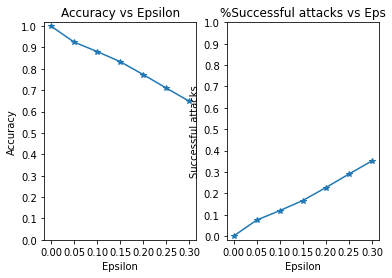

In [38]:
fig, ax = plt.subplots(1, 2)
_ = ax[0].plot(EPSILONS, accuracies, "*-")
_ = ax[0].set_yticks(np.arange(0, 1.1, step=0.1))
_ = ax[0].set_xticks(np.arange(0, .35, step=0.05))
_ = ax[0].set_title("Accuracy vs Epsilon")
_ = ax[0].set_xlabel("Epsilon")
_ = ax[0].set_ylabel("Accuracy")

_ = ax[1].plot(EPSILONS, total_succesful_attacks_list, "*-")
_ = ax[1].set_yticks(np.arange(0, 1.1, step=0.1))
_ = ax[1].set_xticks(np.arange(0, .35, step=0.05))
_ = ax[1].set_title("%Successful attacks vs Eps")
_ = ax[1].set_xlabel("Epsilon")
_ = ax[1].set_ylabel("Successful attacks")


**Targeted attacks**

Original model

In [37]:
accuracies = []
examples = []
total_succesful_attacks_list = []

# for model in [model_beta_001, model_beta_dyn]

# Run test for each epsilon
for eps in tqdm(EPSILONS):
    acc, total_succesful_attacks, ex = run_adverserial_attacks(model, device, val_data_loader, eps, is_image=False, target_label=805)
    accuracies.append(acc)
    total_succesful_attacks_list.append(total_succesful_attacks)    
    examples.append(ex)

 14%|██████                                    | 1/7 [11:00<1:06:00, 660.07s/it]

Epsilon: 0	Test Accuracy = 38566 / 49929 = 0.7724168300628662	 %succesful attacks: 0.0	 Out of total of 50016 data points


 29%|████████████▌                               | 2/7 [22:00<55:00, 660.14s/it]

Epsilon: 0.05	Test Accuracy = 28398 / 49929 = 0.5687676668167114	 %succesful attacks: 0.0299625468164794	 Out of total of 50016 data points


 43%|██████████████████▊                         | 3/7 [33:02<44:03, 660.96s/it]

Epsilon: 0.1	Test Accuracy = 26429 / 49929 = 0.529331624507904	 %succesful attacks: 0.0263974844278876	 Out of total of 50016 data points


 57%|█████████████████████████▏                  | 4/7 [44:06<33:06, 662.14s/it]

Epsilon: 0.15	Test Accuracy = 25654 / 49929 = 0.5138096213340759	 %succesful attacks: 0.02147048809309219	 Out of total of 50016 data points


 71%|███████████████████████████████▍            | 5/7 [55:10<22:06, 663.02s/it]

Epsilon: 0.2	Test Accuracy = 25064 / 49929 = 0.5019928216934204	 %succesful attacks: 0.017584970658334836	 Out of total of 50016 data points


 86%|████████████████████████████████████      | 6/7 [1:06:14<11:03, 663.28s/it]

Epsilon: 0.25	Test Accuracy = 24425 / 49929 = 0.4891946613788605	 %succesful attacks: 0.014280277994752549	 Out of total of 50016 data points


100%|██████████████████████████████████████████| 7/7 [1:17:20<00:00, 662.93s/it]

Epsilon: 0.3	Test Accuracy = 23646 / 49929 = 0.47359248995780945	 %succesful attacks: 0.012197320194676441	 Out of total of 50016 data points


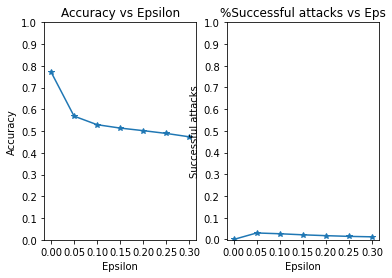

In [39]:
fig, ax = plt.subplots(1, 2)
_ = ax[0].plot(EPSILONS, accuracies, "*-")
_ = ax[0].set_yticks(np.arange(0, 1.1, step=0.1))
_ = ax[0].set_xticks(np.arange(0, .35, step=0.05))
_ = ax[0].set_title("Accuracy vs Epsilon")
_ = ax[0].set_xlabel("Epsilon")
_ = ax[0].set_ylabel("Accuracy")

_ = ax[1].plot(EPSILONS, total_succesful_attacks_list, "*-")
_ = ax[1].set_yticks(np.arange(0, 1.1, step=0.1))
_ = ax[1].set_xticks(np.arange(0, .35, step=0.05))
_ = ax[1].set_title("%Successful attacks vs Eps")
_ = ax[1].set_xlabel("Epsilon")
_ = ax[1].set_ylabel("Successful attacks")


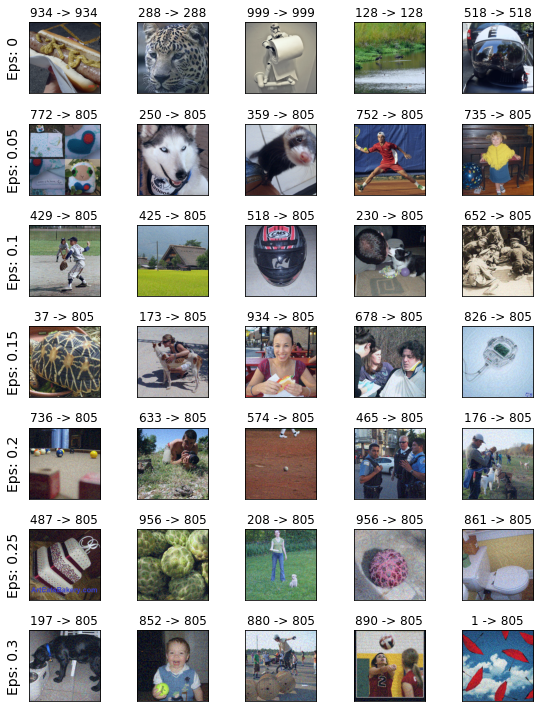

In [62]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(EPSILONS)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(EPSILONS),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(EPSILONS[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        normalized_ex = np.transpose( (ex - ex.min()) / (ex.max() - ex.min()) , (1, 2, 0))
        plt.imshow(normalized_ex)
plt.tight_layout()
plt.show()

Constant beta

In [49]:
accuracies = []
examples = []
total_succesful_attacks_list = []

# for model in [model_beta_001, model_beta_dyn]

# Run test for each epsilon
for eps in tqdm(EPSILONS):
    acc, total_succesful_attacks, ex = run_adverserial_attacks(model_beta_001, device, logits_val_dataloader, eps, is_image=False, target_label=805)
    accuracies.append(acc)
    total_succesful_attacks_list.append(total_succesful_attacks)    
    examples.append(ex)

 14%|██████▍                                      | 1/7 [00:03<00:20,  3.43s/it]

Epsilon: 0	Test Accuracy = 36628 / 49933 = 0.7335429191589355	 %succesful attacks: 0.0	 Out of total of 50016 data points


 29%|████████████▊                                | 2/7 [00:06<00:16,  3.35s/it]

Epsilon: 0.05	Test Accuracy = 18288 / 49933 = 0.36625078320503235	 %succesful attacks: 0.0021628982837001583	 Out of total of 50016 data points


 43%|███████████████████▎                         | 3/7 [00:10<00:13,  3.33s/it]

Epsilon: 0.1	Test Accuracy = 8271 / 49933 = 0.16564196348190308	 %succesful attacks: 0.005907916608255062	 Out of total of 50016 data points


 57%|█████████████████████████▋                   | 4/7 [00:13<00:09,  3.32s/it]

Epsilon: 0.15	Test Accuracy = 4309 / 49933 = 0.08629563450813293	 %succesful attacks: 0.00783049286043298	 Out of total of 50016 data points


 71%|████████████████████████████████▏            | 5/7 [00:16<00:06,  3.31s/it]

Epsilon: 0.2	Test Accuracy = 2300 / 49933 = 0.04606172442436218	 %succesful attacks: 0.006929285242224581	 Out of total of 50016 data points


 86%|██████████████████████████████████████▌      | 6/7 [00:19<00:03,  3.31s/it]

Epsilon: 0.25	Test Accuracy = 1355 / 49933 = 0.027136363089084625	 %succesful attacks: 0.0060881581318967416	 Out of total of 50016 data points


100%|█████████████████████████████████████████████| 7/7 [00:23<00:00,  3.32s/it]

Epsilon: 0.3	Test Accuracy = 895 / 49933 = 0.01792401820421219	 %succesful attacks: 0.005727675084613382	 Out of total of 50016 data points


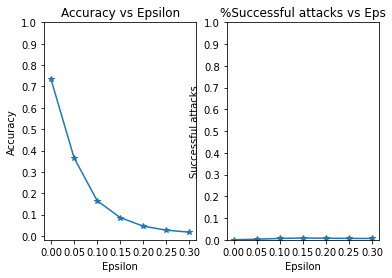

In [50]:
fig, ax = plt.subplots(1, 2)
_ = ax[0].plot(EPSILONS, accuracies, "*-")
_ = ax[0].set_yticks(np.arange(0, 1.1, step=0.1))
_ = ax[0].set_xticks(np.arange(0, .35, step=0.05))
_ = ax[0].set_title("Accuracy vs Epsilon")
_ = ax[0].set_xlabel("Epsilon")
_ = ax[0].set_ylabel("Accuracy")

_ = ax[1].plot(EPSILONS, total_succesful_attacks_list, "*-")
_ = ax[1].set_yticks(np.arange(0, 1.1, step=0.1))
_ = ax[1].set_xticks(np.arange(0, .35, step=0.05))
_ = ax[1].set_title("%Successful attacks vs Eps")
_ = ax[1].set_xlabel("Epsilon")
_ = ax[1].set_ylabel("Successful attacks")


Dynamic beta

In [51]:
accuracies = []
examples = []
total_succesful_attacks_list = []

# for model in [model_beta_001, model_beta_dyn]

# Run test for each epsilon
for eps in tqdm(EPSILONS):
    acc, total_succesful_attacks, ex = run_adverserial_attacks(model_beta_dyn, device, logits_val_dataloader, eps, is_image=False, target_label=805)
    accuracies.append(acc)
    total_succesful_attacks_list.append(total_succesful_attacks)    
    examples.append(ex)

 14%|██████▍                                      | 1/7 [00:03<00:20,  3.40s/it]

Epsilon: 0	Test Accuracy = 37067 / 49938 = 0.7422603964805603	 %succesful attacks: 0.0	 Out of total of 50016 data points


 29%|████████████▊                                | 2/7 [00:06<00:16,  3.34s/it]

Epsilon: 0.05	Test Accuracy = 27300 / 49938 = 0.5466778874397278	 %succesful attacks: 0.00014017381553125876	 Out of total of 50016 data points


 43%|███████████████████▎                         | 3/7 [00:09<00:13,  3.31s/it]

Epsilon: 0.1	Test Accuracy = 10041 / 49938 = 0.20106932520866394	 %succesful attacks: 8.009932316071929e-05	 Out of total of 50016 data points


 57%|█████████████████████████▋                   | 4/7 [00:13<00:09,  3.30s/it]

Epsilon: 0.15	Test Accuracy = 5506 / 49938 = 0.11025671660900116	 %succesful attacks: 0.0	 Out of total of 50016 data points


 71%|████████████████████████████████▏            | 5/7 [00:16<00:06,  3.30s/it]

Epsilon: 0.2	Test Accuracy = 4033 / 49938 = 0.08076014369726181	 %succesful attacks: 2.0024830790179822e-05	 Out of total of 50016 data points


 86%|██████████████████████████████████████▌      | 6/7 [00:19<00:03,  3.29s/it]

Epsilon: 0.25	Test Accuracy = 3322 / 49938 = 0.06652248650789261	 %succesful attacks: 4.0049661580359644e-05	 Out of total of 50016 data points


100%|█████████████████████████████████████████████| 7/7 [00:23<00:00,  3.31s/it]

Epsilon: 0.3	Test Accuracy = 2850 / 49938 = 0.0570707693696022	 %succesful attacks: 6.007449237053947e-05	 Out of total of 50016 data points


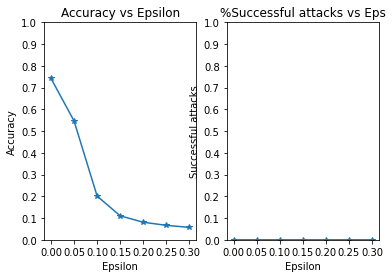

In [52]:
fig, ax = plt.subplots(1, 2)
_ = ax[0].plot(EPSILONS, accuracies, "*-")
_ = ax[0].set_yticks(np.arange(0, 1.1, step=0.1))
_ = ax[0].set_xticks(np.arange(0, .35, step=0.05))
_ = ax[0].set_title("Accuracy vs Epsilon")
_ = ax[0].set_xlabel("Epsilon")
_ = ax[0].set_ylabel("Accuracy")

_ = ax[1].plot(EPSILONS, total_succesful_attacks_list, "*-")
_ = ax[1].set_yticks(np.arange(0, 1.1, step=0.1))
_ = ax[1].set_xticks(np.arange(0, .35, step=0.05))
_ = ax[1].set_title("%Successful attacks vs Eps")
_ = ax[1].set_xlabel("Epsilon")
_ = ax[1].set_ylabel("Successful attacks")


#### Hybrid model

In [ ]:
class HybridModel(nn.Module):
    """
    Head is inception, classifier is VIB
    """
    def __init__(self, inception_model, vib_model, device):
        super(HybridModel, self).__init__()
        self.device = device
        self.inception_model = inception_model
        self.inception_model.fc = torch.nn.Identity()
        self.vib_model = vib_model
        self.train_loss = []
        self.test_loss = []

    def forward(self, x):
        encoded = self.inception_model(x)
        logits = self.vib_model(encoded)
        return logits

Constant beta

In [65]:
hybrid_model = HybridModel(model, model_beta_001, device)

Untargeted

In [66]:
accuracies = []
examples = []
total_succesful_attacks_list = []

# for model in [model_beta_001, model_beta_dyn]

# Run test for each epsilon
for eps in tqdm(EPSILONS):
    acc, total_succesful_attacks, ex = run_adverserial_attacks(hybrid_model, device, val_data_loader, eps, is_image=False)#, target_label=805)
    accuracies.append(acc)
    total_succesful_attacks_list.append(total_succesful_attacks)    
    examples.append(ex)

 14%|██████                                    | 1/7 [10:14<1:01:28, 614.78s/it]

Epsilon: 0	Test Accuracy = 36672 / 36674 = 0.9999454617500305	 %succesful attacks: 5.453454763592736e-05	 Out of total of 50016 data points


 29%|████████████▌                               | 2/7 [20:43<51:53, 622.69s/it]

Epsilon: 0.05	Test Accuracy = 15930 / 36674 = 0.43436768651008606	 %succesful attacks: 0.5656323280798385	 Out of total of 50016 data points


 43%|██████████████████▊                         | 3/7 [31:16<41:49, 627.47s/it]

Epsilon: 0.1	Test Accuracy = 15732 / 36674 = 0.42896875739097595	 %succesful attacks: 0.5710312482957954	 Out of total of 50016 data points


 57%|█████████████████████████▏                  | 4/7 [41:49<31:29, 629.93s/it]

Epsilon: 0.15	Test Accuracy = 15751 / 36674 = 0.42948684096336365	 %succesful attacks: 0.5705131700932541	 Out of total of 50016 data points


 71%|███████████████████████████████▍            | 5/7 [52:25<21:03, 631.96s/it]

Epsilon: 0.2	Test Accuracy = 15786 / 36674 = 0.4304411709308624	 %succesful attacks: 0.5695588155096254	 Out of total of 50016 data points


 86%|████████████████████████████████████      | 6/7 [1:03:01<10:33, 633.45s/it]

Epsilon: 0.25	Test Accuracy = 15684 / 36674 = 0.42765992879867554	 %succesful attacks: 0.5723400774390577	 Out of total of 50016 data points


100%|██████████████████████████████████████████| 7/7 [1:13:40<00:00, 631.47s/it]

Epsilon: 0.3	Test Accuracy = 15514 / 36674 = 0.4230244755744934	 %succesful attacks: 0.5769755139881114	 Out of total of 50016 data points


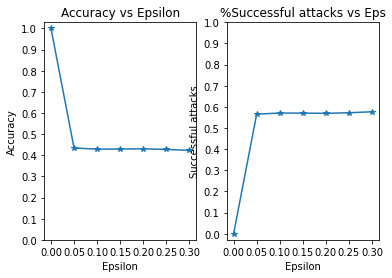

In [67]:
fig, ax = plt.subplots(1, 2)
_ = ax[0].plot(EPSILONS, accuracies, "*-")
_ = ax[0].set_yticks(np.arange(0, 1.1, step=0.1))
_ = ax[0].set_xticks(np.arange(0, .35, step=0.05))
_ = ax[0].set_title("Accuracy vs Epsilon")
_ = ax[0].set_xlabel("Epsilon")
_ = ax[0].set_ylabel("Accuracy")

_ = ax[1].plot(EPSILONS, total_succesful_attacks_list, "*-")
_ = ax[1].set_yticks(np.arange(0, 1.1, step=0.1))
_ = ax[1].set_xticks(np.arange(0, .35, step=0.05))
_ = ax[1].set_title("%Successful attacks vs Eps")
_ = ax[1].set_xlabel("Epsilon")
_ = ax[1].set_ylabel("Successful attacks")


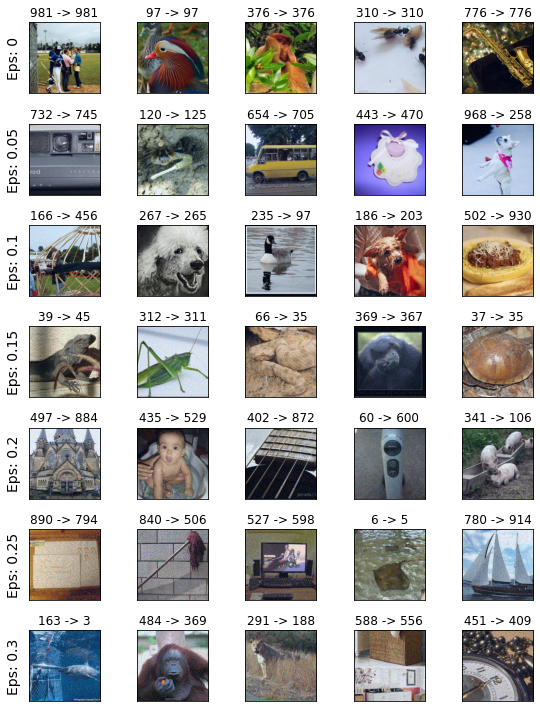

In [68]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(EPSILONS)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(EPSILONS),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(EPSILONS[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        normalized_ex = np.transpose( (ex - ex.min()) / (ex.max() - ex.min()) , (1, 2, 0))
        plt.imshow(normalized_ex)
plt.tight_layout()
plt.show()

Targeted

Dynamic beta

In [70]:
hybrid_model = HybridModel(model, model_beta_dyn, device)

Unargeted

In [71]:
accuracies = []
examples = []
total_succesful_attacks_list = []

# for model in [model_beta_001, model_beta_dyn]

# Run test for each epsilon
for eps in tqdm(EPSILONS):
    acc, total_succesful_attacks, ex = run_adverserial_attacks(hybrid_model, device, val_data_loader, eps, is_image=False)#, target_label=805)
    accuracies.append(acc)
    total_succesful_attacks_list.append(total_succesful_attacks)    
    examples.append(ex)

 14%|██████                                    | 1/7 [10:20<1:02:03, 620.65s/it]

Epsilon: 0	Test Accuracy = 37108 / 37112 = 0.9998922348022461	 %succesful attacks: 0.00010778184953653804	 Out of total of 50016 data points


 29%|████████████▌                               | 2/7 [20:53<52:18, 627.75s/it]

Epsilon: 0.05	Test Accuracy = 20049 / 37112 = 0.5402295589447021	 %succesful attacks: 0.4597704246604872	 Out of total of 50016 data points


 43%|██████████████████▊                         | 3/7 [31:26<42:00, 630.18s/it]

Epsilon: 0.1	Test Accuracy = 18573 / 37112 = 0.5004580616950989	 %succesful attacks: 0.4995419271394697	 Out of total of 50016 data points


 57%|█████████████████████████▏                  | 4/7 [42:02<31:37, 632.58s/it]

Epsilon: 0.15	Test Accuracy = 17838 / 37112 = 0.48065316677093506	 %succesful attacks: 0.5193468419918086	 Out of total of 50016 data points


 71%|███████████████████████████████▍            | 5/7 [52:39<21:08, 634.10s/it]

Epsilon: 0.2	Test Accuracy = 17415 / 37112 = 0.4692552387714386	 %succesful attacks: 0.5307447725802975	 Out of total of 50016 data points


 86%|████████████████████████████████████      | 6/7 [1:03:16<10:35, 635.20s/it]

Epsilon: 0.25	Test Accuracy = 17004 / 37112 = 0.45818063616752625	 %succesful attacks: 0.5418193576201767	 Out of total of 50016 data points


100%|██████████████████████████████████████████| 7/7 [1:13:53<00:00, 633.39s/it]

Epsilon: 0.3	Test Accuracy = 16474 / 37112 = 0.443899542093277	 %succesful attacks: 0.5561004526837681	 Out of total of 50016 data points


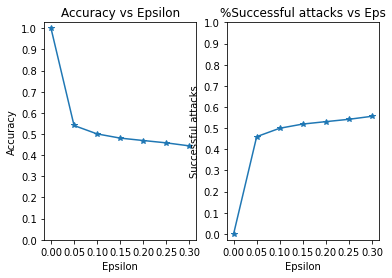

In [72]:
fig, ax = plt.subplots(1, 2)
_ = ax[0].plot(EPSILONS, accuracies, "*-")
_ = ax[0].set_yticks(np.arange(0, 1.1, step=0.1))
_ = ax[0].set_xticks(np.arange(0, .35, step=0.05))
_ = ax[0].set_title("Accuracy vs Epsilon")
_ = ax[0].set_xlabel("Epsilon")
_ = ax[0].set_ylabel("Accuracy")

_ = ax[1].plot(EPSILONS, total_succesful_attacks_list, "*-")
_ = ax[1].set_yticks(np.arange(0, 1.1, step=0.1))
_ = ax[1].set_xticks(np.arange(0, .35, step=0.05))
_ = ax[1].set_title("%Successful attacks vs Eps")
_ = ax[1].set_xlabel("Epsilon")
_ = ax[1].set_ylabel("Successful attacks")


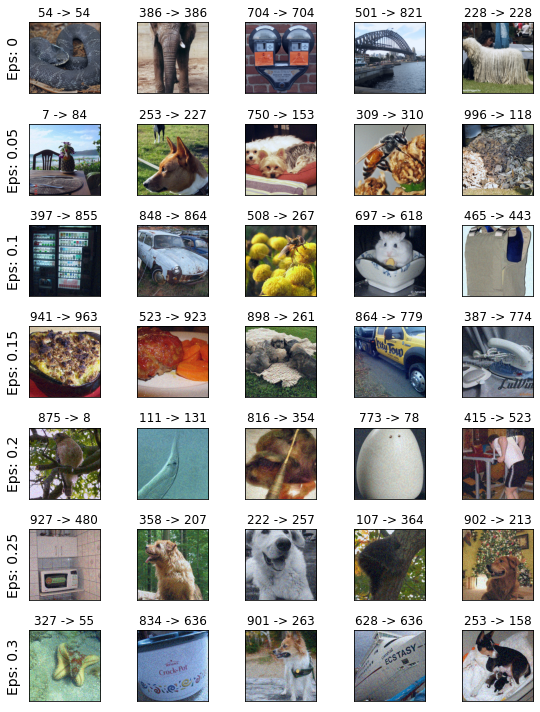

In [73]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(EPSILONS)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(EPSILONS),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(EPSILONS[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        normalized_ex = np.transpose( (ex - ex.min()) / (ex.max() - ex.min()) , (1, 2, 0))
        plt.imshow(normalized_ex)
plt.tight_layout()
plt.show()

Targeted

In [75]:
accuracies = []
examples = []
total_succesful_attacks_list = []

# for model in [model_beta_001, model_beta_dyn]

# Run test for each epsilon
for eps in tqdm(EPSILONS):
    acc, total_succesful_attacks, ex = run_adverserial_attacks(hybrid_model, device, val_data_loader, eps, is_image=False, target_label=805)
    accuracies.append(acc)
    total_succesful_attacks_list.append(total_succesful_attacks)    
    examples.append(ex)

 14%|██████                                    | 1/7 [10:43<1:04:23, 643.88s/it]

Epsilon: 0	Test Accuracy = 37067 / 49938 = 0.7422603964805603	 %succesful attacks: 0.0	 Out of total of 50016 data points


 29%|████████████▌                               | 2/7 [21:43<54:24, 652.95s/it]

Epsilon: 0.05	Test Accuracy = 26287 / 49938 = 0.5263926982879639	 %succesful attacks: 0.00040049661580359645	 Out of total of 50016 data points


 43%|██████████████████▊                         | 3/7 [32:47<43:52, 658.03s/it]

Epsilon: 0.1	Test Accuracy = 24864 / 49938 = 0.4978973865509033	 %succesful attacks: 0.0005807200929152149	 Out of total of 50016 data points


 57%|█████████████████████████▏                  | 4/7 [43:51<33:01, 660.37s/it]

Epsilon: 0.15	Test Accuracy = 24164 / 49938 = 0.48388001322746277	 %succesful attacks: 0.0006007449237053947	 Out of total of 50016 data points


 71%|███████████████████████████████▍            | 5/7 [54:55<22:03, 661.89s/it]

Epsilon: 0.2	Test Accuracy = 23582 / 49938 = 0.472225546836853	 %succesful attacks: 0.00046057110817413594	 Out of total of 50016 data points


 86%|████████████████████████████████████      | 6/7 [1:05:59<11:02, 662.41s/it]

Epsilon: 0.25	Test Accuracy = 23048 / 49938 = 0.4615322947502136	 %succesful attacks: 0.00042052144659377626	 Out of total of 50016 data points


100%|██████████████████████████████████████████| 7/7 [1:17:02<00:00, 660.38s/it]

Epsilon: 0.3	Test Accuracy = 22310 / 49938 = 0.44675397872924805	 %succesful attacks: 0.00048059593896431575	 Out of total of 50016 data points


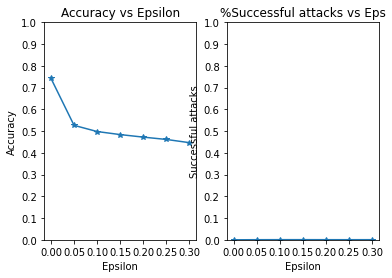

In [76]:
fig, ax = plt.subplots(1, 2)
_ = ax[0].plot(EPSILONS, accuracies, "*-")
_ = ax[0].set_yticks(np.arange(0, 1.1, step=0.1))
_ = ax[0].set_xticks(np.arange(0, .35, step=0.05))
_ = ax[0].set_title("Accuracy vs Epsilon")
_ = ax[0].set_xlabel("Epsilon")
_ = ax[0].set_ylabel("Accuracy")

_ = ax[1].plot(EPSILONS, total_succesful_attacks_list, "*-")
_ = ax[1].set_yticks(np.arange(0, 1.1, step=0.1))
_ = ax[1].set_xticks(np.arange(0, .35, step=0.05))
_ = ax[1].set_title("%Successful attacks vs Eps")
_ = ax[1].set_xlabel("Epsilon")
_ = ax[1].set_ylabel("Successful attacks")


### New models

Constant high beta

In [65]:
def fetch_scalar_data(run_id, metric_name):
    api = wandb.Api()
    run = api.run(f"reichman_uni/dynamic_beta/{run_id}")
    history = run.history(keys=[metric_name], samples=1000)  # You can adjust the number of samples
    return history[metric_name].values

In [247]:
run_id = "62f3f4hn"

run_train_loss = fetch_scalar_data(run_id, "charts/epoch_train_loss")
run_total_kld = fetch_scalar_data(run_id, "charts/epoch_total_kld")


In [248]:
delta_kld = run_total_kld[:-1] - run_total_kld[1:]
delta_loss = run_train_loss[:-1] - run_train_loss[1:]

In [251]:
delta_kld / (delta_kld + delta_loss)

array([0.99929004, 0.99956179, 0.99926216, 0.99880411, 0.98315367,
       0.99830395, 0.99893169, 0.99937622, 1.01074496, 0.99958369,
       0.99949236, 0.99973432, 0.99958175, 0.99981343, 0.99970865,
       0.99984191, 0.99980794, 0.99986779, 0.99985331, 0.99981655,
       1.000046  , 0.99995004, 0.99997715, 0.99647001, 0.99983752,
       1.00005015, 1.00010461, 1.00005085, 1.00060665, 1.00054354,
       1.00007487, 1.00017103, 0.99917865, 0.99878049, 1.02163553,
       1.00007517, 1.00089279, 1.00033132, 0.99958811, 1.00015533,
       1.00112741, 0.9988394 , 0.99998897, 1.00146636, 0.99853653,
       1.00002772, 1.00402725, 1.00010225, 1.00044733, 1.00016155,
       1.00010533, 1.00750154, 1.00015628, 1.00010333, 1.00030388,
       1.00063888, 1.0004295 , 1.00465267, 1.00065349, 1.00051396,
       0.99425663, 1.00367204, 1.00288562, 1.00129841, 0.99582042,
       0.998231  , 1.0024784 , 0.99930716, 0.99733383])

In [79]:
run_id = "62f3f4hn"
metric_name = "charts/avg_epoch_ratio"

scalar_data = fetch_scalar_data(run_id, metric_name)
average = np.mean(scalar_data)

print(f"Average of {metric_name} over run {run_id}: {average}")

Average of charts/avg_epoch_ratio over run 62f3f4hn: 0.039361155325812955


#### Constant model wth $\beta=0.04$ and minibatches

In [12]:
LR = 1e-4
EPOCHS = 70
BETA = 4e-2
NUM_MINIBATCHES = 4

run_name = f"vib_imagenet_beta0.04_new_logits_70epochs_time_{int(time.time())}"

constant_vib_beta_004_classifier = VIB(2048, device).to(device)
optimizer = optim.Adam(constant_vib_beta_004_classifier.parameters(), LR / NUM_MINIBATCHES, betas=(0.5,0.999))
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.97)

loop_data(constant_vib_beta_004_classifier, logits_trian_dataloader, logits_val_dataloader, BETA,
          num_minibatches=NUM_MINIBATCHES, model_save_path='/tmp', epochs=EPOCHS, device=device,
          optimizer=optimizer, scheduler=scheduler, is_ppo=False, run_name=run_name)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nirzvi89 (reichman_uni). Use `wandb login --relogin` to force relogin


100%|███████████████████████████████████████| 70/70 [13:18:43<00:00, 684.63s/it]


In [14]:
# with open(f'/D/models/{run_name}.pkl', 'wb') as f:
#     pickle.dump(constant_vib_beta_004_classifier, f)
# print(f'Saved model to /D/models/{run_name}.pkl')

Saved model to /D/models/vib_imagenet_beta0.04_new_logits_70epochs_time_1682964900.pkl


In [15]:
test_model(constant_vib_beta_004_classifier, logits_val_dataloader)

100%|█████████████████████████████████████| 1563/1563 [00:01<00:00, 1458.19it/s]

tensor(0.7404, device='cuda:0')
acc: None


In [14]:
with open("/D/models/vib_imagenet_beta0.04_new_logits_70epochs_time_1682964900.pkl", 'rb') as f:
    constant_vib_beta_004_classifier = pickle.load(f)

In [15]:
hybrid_model = HybridModel(model, constant_vib_beta_004_classifier, device)

In [16]:
accuracies = []
examples = []
total_succesful_attacks_list = []

# for model in [model_beta_001, model_beta_dyn]

# Run test for each epsilon
for eps in tqdm(EPSILONS):
    acc, total_succesful_attacks, ex = run_adverserial_attacks(hybrid_model, device, val_data_loader, eps, is_image=False)#, target_label=805)
    accuracies.append(acc)
    total_succesful_attacks_list.append(total_succesful_attacks)    
    examples.append(ex)

 14%|██████                                    | 1/7 [10:19<1:01:58, 619.70s/it]

Epsilon: 0	Test Accuracy = 37020 / 37022 = 0.9999459981918335	 %succesful attacks: 5.402193290475933e-05	 Out of total of 50016 data points


 29%|████████████▌                               | 2/7 [20:50<52:10, 626.16s/it]

Epsilon: 0.05	Test Accuracy = 17609 / 37022 = 0.4756360948085785	 %succesful attacks: 0.5243638917400465	 Out of total of 50016 data points


 43%|██████████████████▊                         | 3/7 [31:22<41:56, 629.10s/it]

Epsilon: 0.1	Test Accuracy = 17143 / 37022 = 0.4630489945411682	 %succesful attacks: 0.5369510021068554	 Out of total of 50016 data points


 57%|█████████████████████████▏                  | 4/7 [41:56<31:32, 630.89s/it]

Epsilon: 0.15	Test Accuracy = 17008 / 37022 = 0.45940253138542175	 %succesful attacks: 0.5405974825779266	 Out of total of 50016 data points


 71%|███████████████████████████████▍            | 5/7 [52:27<21:02, 631.05s/it]

Epsilon: 0.2	Test Accuracy = 16883 / 37022 = 0.4560261368751526	 %succesful attacks: 0.5439738533844741	 Out of total of 50016 data points


 86%|████████████████████████████████████      | 6/7 [1:02:59<10:31, 631.29s/it]

Epsilon: 0.25	Test Accuracy = 16659 / 37022 = 0.4499756991863251	 %succesful attacks: 0.5500243098698071	 Out of total of 50016 data points


100%|██████████████████████████████████████████| 7/7 [1:13:32<00:00, 630.29s/it]

Epsilon: 0.3	Test Accuracy = 16338 / 37022 = 0.44130516052246094	 %succesful attacks: 0.5586948301010211	 Out of total of 50016 data points


Targeted

In [18]:
accuracies = []
examples = []
total_succesful_attacks_list = []

# for model in [model_beta_001, model_beta_dyn]

# Run test for each epsilon
for eps in tqdm(EPSILONS):
    acc, total_succesful_attacks, ex = run_adverserial_attacks(hybrid_model, device, val_data_loader, eps, is_image=False, target_label=805)
    accuracies.append(acc)
    total_succesful_attacks_list.append(total_succesful_attacks)    
    examples.append(ex)

 14%|██████                                    | 1/7 [10:46<1:04:40, 646.75s/it]

Epsilon: 0	Test Accuracy = 36976 / 49940 = 0.7404084801673889	 %succesful attacks: 0.0	 Out of total of 50016 data points


 29%|████████████▌                               | 2/7 [21:47<54:34, 654.92s/it]

Epsilon: 0.05	Test Accuracy = 28238 / 49940 = 0.5654385089874268	 %succesful attacks: 0.0009411293552262715	 Out of total of 50016 data points


 43%|██████████████████▊                         | 3/7 [32:46<43:47, 656.80s/it]

Epsilon: 0.1	Test Accuracy = 27479 / 49940 = 0.5502402782440186	 %succesful attacks: 0.0010612735282338806	 Out of total of 50016 data points


 57%|█████████████████████████▏                  | 4/7 [43:50<32:59, 659.67s/it]

Epsilon: 0.15	Test Accuracy = 26786 / 49940 = 0.5363636612892151	 %succesful attacks: 0.0011213456147376852	 Out of total of 50016 data points


 71%|███████████████████████████████▍            | 5/7 [54:54<22:02, 661.12s/it]

Epsilon: 0.2	Test Accuracy = 26097 / 49940 = 0.522567093372345	 %succesful attacks: 0.0009010812975570685	 Out of total of 50016 data points


 86%|████████████████████████████████████      | 6/7 [1:06:00<11:02, 662.96s/it]

Epsilon: 0.25	Test Accuracy = 25307 / 49940 = 0.5067480802536011	 %succesful attacks: 0.0009010812975570685	 Out of total of 50016 data points


100%|██████████████████████████████████████████| 7/7 [1:17:07<00:00, 661.10s/it]

Epsilon: 0.3	Test Accuracy = 24443 / 49940 = 0.48944732546806335	 %succesful attacks: 0.0008209851822186623	 Out of total of 50016 data points


Best so far on lowest beta:
- 54% acc for dyn
    * Scored 74.22% on val set
- 47.5% acc for const with $\beta=0.04$ which is same as our average
    * Scored 74.04% acc on val set
- 43% acc for const with $\beta=0.01$
- 32% acc for original

##### Dynamic beta with higher beta

In [22]:
LR = 1e-4
EPOCHS = 70
BETA = 0.1
NUM_MINIBATCHES = 4

run_name = f"vib_imagenet_dynamic_beta_01_epochs_time_{int(time.time())}"

dyn_beta_01 = VIB(2048, device).to(device)
optimizer = optim.Adam(dyn_beta_01.parameters(), LR / NUM_MINIBATCHES, betas=(0.5,0.999))
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.97)

loop_data(dyn_beta_01, logits_trian_dataloader, logits_val_dataloader, BETA,
          num_minibatches=NUM_MINIBATCHES, model_save_path='/tmp', epochs=EPOCHS, device=device,
          optimizer=optimizer, scheduler=scheduler, is_ppo=True, run_name=run_name)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nirzvi89 (reichman_uni). Use `wandb login --relogin` to force relogin


100%|███████████████████████████████████████| 70/70 [13:40:03<00:00, 702.91s/it]


In [23]:
# with open(f'/D/models/{run_name}.pkl', 'wb') as f:
#     pickle.dump(dyn_beta_01, f)
# print(f'Saved model to /D/models/{run_name}.pkl')

Saved model to /D/models/vib_imagenet_dynamic_beta_01_epochs_time_1683025405.pkl


In [19]:
with open('/D/models/vib_imagenet_dynamic_beta_01_epochs_time_1683025405.pkl', 'rb') as f:
    dyn_beta_01 = pickle.load(f)

In [23]:
hybrid_model = HybridModel(model, dyn_beta_01, device)

In [27]:
test_model(hybrid_model, val_data_loader)

100%|███████████████████████████████████████| 1563/1563 [04:44<00:00,  5.48it/s]

tensor(0.7438, device='cuda:0')
acc: None


In [ ]:
EPSILONS = [.05, .1, .15, .2, .25, .3]

untargeted

In [25]:
accuracies = []
examples = []
total_succesful_attacks_list = []

# for model in [model_beta_001, model_beta_dyn]

# Run test for each epsilon
for eps in tqdm(EPSILONS):
    acc, total_succesful_attacks, ex = run_adverserial_attacks(hybrid_model, device, val_data_loader, eps, is_image=False)#, target_label=805)
    accuracies.append(acc)
    total_succesful_attacks_list.append(total_succesful_attacks)    
    examples.append(ex)

 17%|███████▎                                    | 1/6 [10:11<50:59, 611.86s/it]

Epsilon: 0.05	Test Accuracy = 10835 / 37189 = 0.2913495898246765	 %succesful attacks: 0.7086504073785259	 Out of total of 50016 data points


 33%|██████████████▋                             | 2/6 [20:32<41:08, 617.12s/it]

Epsilon: 0.1	Test Accuracy = 9911 / 37189 = 0.26650354266166687	 %succesful attacks: 0.7334964640081745	 Out of total of 50016 data points


 50%|██████████████████████                      | 3/6 [30:51<30:54, 618.12s/it]

Epsilon: 0.15	Test Accuracy = 9942 / 37189 = 0.2673371136188507	 %succesful attacks: 0.7326628841861841	 Out of total of 50016 data points


 67%|█████████████████████████████▎              | 4/6 [41:13<20:39, 619.60s/it]

Epsilon: 0.2	Test Accuracy = 10103 / 37189 = 0.27166634798049927	 %succesful attacks: 0.7283336470461695	 Out of total of 50016 data points


 83%|████████████████████████████████████▋       | 5/6 [51:39<10:21, 621.81s/it]

Epsilon: 0.25	Test Accuracy = 10316 / 37189 = 0.2773938477039337	 %succesful attacks: 0.7226061469789454	 Out of total of 50016 data points


100%|██████████████████████████████████████████| 6/6 [1:02:06<00:00, 621.15s/it]

Epsilon: 0.3	Test Accuracy = 10389 / 37189 = 0.27935680747032166	 %succesful attacks: 0.7206432009465165	 Out of total of 50016 data points


Targeted

In [26]:
accuracies = []
examples = []
total_succesful_attacks_list = []

# for model in [model_beta_001, model_beta_dyn]

# Run test for each epsilon
for eps in tqdm(EPSILONS):
    acc, total_succesful_attacks, ex = run_adverserial_attacks(hybrid_model, device, val_data_loader, eps, is_image=False, target_label=805)
    accuracies.append(acc)
    total_succesful_attacks_list.append(total_succesful_attacks)    
    examples.append(ex)

 17%|███████▎                                    | 1/6 [10:53<54:25, 653.14s/it]

Epsilon: 0.05	Test Accuracy = 32719 / 49936 = 0.6552186608314514	 %succesful attacks: 0.0004405639218199295	 Out of total of 50016 data points


 33%|██████████████▋                             | 2/6 [21:46<43:32, 653.04s/it]

Epsilon: 0.1	Test Accuracy = 31519 / 49936 = 0.631187915802002	 %succesful attacks: 0.0006408202499198974	 Out of total of 50016 data points


 50%|██████████████████████                      | 3/6 [32:39<32:39, 653.06s/it]

Epsilon: 0.15	Test Accuracy = 30515 / 49936 = 0.6110821962356567	 %succesful attacks: 0.0006207946171099006	 Out of total of 50016 data points


 67%|█████████████████████████████▎              | 4/6 [43:34<21:47, 653.81s/it]

Epsilon: 0.2	Test Accuracy = 29643 / 49936 = 0.5936198234558105	 %succesful attacks: 0.0005607177186799103	 Out of total of 50016 data points


 83%|████████████████████████████████████▋       | 5/6 [54:25<10:53, 653.00s/it]

Epsilon: 0.25	Test Accuracy = 28678 / 49936 = 0.5742951035499573	 %succesful attacks: 0.0005607177186799103	 Out of total of 50016 data points


100%|██████████████████████████████████████████| 6/6 [1:05:22<00:00, 653.75s/it]

Epsilon: 0.3	Test Accuracy = 27617 / 49936 = 0.5530478954315186	 %succesful attacks: 0.0004806151874399231	 Out of total of 50016 data points


#### Dynamic beta with high beta

In [ ]:
LR = 1e-4
EPOCHS = 70
BETA = 1
NUM_MINIBATCHES = 4

run_name = f"vib_imagenet_dynamic_beta_1_epochs_time_{int(time.time())}"

dyn_beta_1 = VIB(2048, device).to(device)
optimizer = optim.Adam(dyn_beta_1.parameters(), LR / NUM_MINIBATCHES, betas=(0.5,0.999))
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.97)

loop_data(dyn_beta_1, logits_trian_dataloader, logits_val_dataloader, BETA,
          num_minibatches=NUM_MINIBATCHES, model_save_path='/tmp', epochs=EPOCHS, device=device,
          optimizer=optimizer, scheduler=scheduler, is_ppo=True, run_name=run_name)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nirzvi89 (reichman_uni). Use `wandb login --relogin` to force relogin


 54%|████████████████████▋                 | 38/70 [7:22:55<6:14:03, 701.35s/it]

In [ ]:
# with open(f'/D/models/{run_name}.pkl', 'wb') as f:
#     pickle.dump(dyn_beta_1, f)
# print(f'Saved model to /D/models/{run_name}.pkl')

In [ ]:
with open('/D/models/vib_imagenet_dynamic_beta_1_epochs_time_1683098947.pkl', 'rb') as f:
    dyn_beta_1 = pickle.load(f)

In [25]:
hybrid_model = HybridModel(model, dyn_beta_1, device)

In [26]:
test_model(hybrid_model, val_data_loader)

100%|███████████████████████████████████████| 1563/1563 [04:43<00:00,  5.52it/s]

tensor(0.7459, device='cuda:0')
acc: None


untargeted

In [32]:
accuracies = []
examples = []
total_succesful_attacks_list = []

# for model in [model_beta_001, model_beta_dyn]

# Run test for each epsilon
for eps in tqdm(EPSILONS):
    acc, total_succesful_attacks, ex = run_adverserial_attacks(hybrid_model, device, val_data_loader, eps, is_image=False)#, target_label=805)
    accuracies.append(acc)
    total_succesful_attacks_list.append(total_succesful_attacks)    
    examples.append(ex)

 17%|███████▎                                    | 1/6 [10:18<51:34, 618.80s/it]

Epsilon: 0.05	Test Accuracy = 9267 / 37297 = 0.24846503138542175	 %succesful attacks: 0.7515349760034319	 Out of total of 50016 data points


 33%|██████████████▋                             | 2/6 [20:46<41:35, 623.80s/it]

Epsilon: 0.1	Test Accuracy = 9105 / 37297 = 0.2441215068101883	 %succesful attacks: 0.7558784888865057	 Out of total of 50016 data points


 50%|██████████████████████                      | 3/6 [31:17<31:21, 627.08s/it]

Epsilon: 0.15	Test Accuracy = 9426 / 37297 = 0.25272810459136963	 %succesful attacks: 0.7472718985441188	 Out of total of 50016 data points


 67%|█████████████████████████████▎              | 4/6 [41:48<20:57, 628.86s/it]

Epsilon: 0.2	Test Accuracy = 9758 / 37297 = 0.2616296112537384	 %succesful attacks: 0.7383703783146097	 Out of total of 50016 data points


 83%|████████████████████████████████████▋       | 5/6 [52:20<10:30, 630.10s/it]

Epsilon: 0.25	Test Accuracy = 10086 / 37297 = 0.27042388916015625	 %succesful attacks: 0.7295761053167815	 Out of total of 50016 data points


100%|██████████████████████████████████████████| 6/6 [1:02:54<00:00, 629.05s/it]

Epsilon: 0.3	Test Accuracy = 10262 / 37297 = 0.27514275908470154	 %succesful attacks: 0.7248572271228249	 Out of total of 50016 data points


Targeted

In [33]:
accuracies = []
examples = []
total_succesful_attacks_list = []

# for model in [model_beta_001, model_beta_dyn]

# Run test for each epsilon
for eps in tqdm(EPSILONS):
    acc, total_succesful_attacks, ex = run_adverserial_attacks(hybrid_model, device, val_data_loader, eps, is_image=False, target_label=805)
    accuracies.append(acc)
    total_succesful_attacks_list.append(total_succesful_attacks)    
    examples.append(ex)

 17%|███████▎                                    | 1/6 [10:55<54:35, 655.11s/it]

Epsilon: 0.05	Test Accuracy = 34041 / 49939 = 0.6816515922546387	 %succesful attacks: 0.0005206351749133943	 Out of total of 50016 data points


 33%|██████████████▋                             | 2/6 [21:48<43:36, 654.24s/it]

Epsilon: 0.1	Test Accuracy = 32878 / 49939 = 0.6583632230758667	 %succesful attacks: 0.000560684034522117	 Out of total of 50016 data points


 50%|██████████████████████                      | 3/6 [32:44<32:44, 654.76s/it]

Epsilon: 0.15	Test Accuracy = 31919 / 49939 = 0.6391597986221313	 %succesful attacks: 0.0005807084643264783	 Out of total of 50016 data points


 67%|█████████████████████████████▎              | 4/6 [43:43<21:53, 656.66s/it]

Epsilon: 0.2	Test Accuracy = 30979 / 49939 = 0.6203368306159973	 %succesful attacks: 0.0006808306133482849	 Out of total of 50016 data points


 83%|████████████████████████████████████▋       | 5/6 [54:43<10:57, 657.84s/it]

Epsilon: 0.25	Test Accuracy = 29847 / 49939 = 0.5976691842079163	 %succesful attacks: 0.0005807084643264783	 Out of total of 50016 data points


100%|██████████████████████████████████████████| 6/6 [1:05:41<00:00, 656.99s/it]

Epsilon: 0.3	Test Accuracy = 28478 / 49939 = 0.570255696773529	 %succesful attacks: 0.0006608061835439236	 Out of total of 50016 data points


Compute $\beta$ as derivative

In [51]:
import math
run_id = "yt6va6ze"

izx_bound = math.log(1000, 2) - fetch_scalar_data(run_id, "charts/epoch_total_kld")
izx_bound = fetch_scalar_data(run_id, "charts/epoch_total_kld")
izy_bound = fetch_scalar_data(run_id, "charts/epoch_classification_loss")

# print(f"Average of {metric_name} over run {run_id}: {average}")

#### Rebuilding for MNIST

In [57]:
from torchvision.datasets import MNIST

Data

In [98]:
MNIST_DATASET_DIR = '/D/datasets/MNIST'
BATCH_SIZE = 128
NUM_WORKERS = 1

transform = transforms.Compose([transforms.Resize((28, 28)), transforms.ToTensor()])

if os.path.isdir(MNIST_DATASET_DIR):
    mnist_train_data = MNIST(root=MNIST_DATASET_DIR, train=True, transform=transform)
    mnist_test_data = MNIST(root=MNIST_DATASET_DIR, train=False, transform=transform)
else:
    os.mkdir(DATASET_DIR)
    mnist_train_data = MNIST(root=MNIST_DATASET_DIR, train=True, download=True, transform=transforms.ToTensor())
    mnist_test_data = MNIST(root=MNIST_DATASET_DIR, train=False, download=True, transform=transforms.ToTensor())

mnist_train_loader = DataLoader(mnist_train_data,
                      batch_size=BATCH_SIZE,
                      shuffle=True,
                      num_workers=NUM_WORKERS,
                      drop_last=True)

mnist_test_loader = DataLoader(mnist_test_data,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=NUM_WORKERS,
                         drop_last=False)

mnist_classes = mnist_train_data.classes

Train basic model

In [177]:
class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 7 * 7 * 4, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
#         x = self.dropout(x)
        x = x.view(-1, 64 * 7 * 7 * 4)
        x = F.relu(self.fc1(x))
#         x = self.dropout(x)
        x = self.fc2(x)
        return x

In [180]:
# Initialize the CNN
mnist_model = MNIST_CNN().to(device)

# Set loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mnist_model.parameters(), lr=0.001)

# Train the CNN
num_epochs = 12

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(mnist_train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = mnist_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {running_loss / (i + 1)}")

print("Training finished")

# Test the CNN
correct = 0
total = 0
with torch.no_grad():
    for data in mnist_test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = mnist_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the test set: {100 * correct / total}%")

Accuracy on the test set: 98.98%


Untargeted attack - original model

In [181]:
accuracies = []
examples = []
total_succesful_attacks_list = []

# Run test for each epsilon
for eps in tqdm(EPSILONS):
    acc, total_succesful_attacks, ex = run_adverserial_attacks(mnist_model, device, mnist_test_loader, eps, is_image=True)#, target_label=805)
    accuracies.append(acc)
    total_succesful_attacks_list.append(total_succesful_attacks)    
    examples.append(ex)

 17%|███████▌                                     | 1/6 [00:00<00:03,  1.34it/s]

Epsilon: 0.05	Test Accuracy = 9703 / 9898 = 0.9802990555763245	 %succesful attacks: 0.019700949686805417	 Out of total of 10112 data points


 33%|███████████████                              | 2/6 [00:01<00:02,  1.34it/s]

Epsilon: 0.1	Test Accuracy = 9172 / 9898 = 0.9266518354415894	 %succesful attacks: 0.07334815114164478	 Out of total of 10112 data points


 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.34it/s]

Epsilon: 0.15	Test Accuracy = 7770 / 9898 = 0.7850070595741272	 %succesful attacks: 0.214992927864215	 Out of total of 10112 data points


 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.33it/s]

Epsilon: 0.2	Test Accuracy = 5174 / 9898 = 0.5227318406105042	 %succesful attacks: 0.47726813497676296	 Out of total of 10112 data points


 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.33it/s]

Epsilon: 0.25	Test Accuracy = 2257 / 9898 = 0.2280258685350418	 %succesful attacks: 0.7719741361891291	 Out of total of 10112 data points


100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.33it/s]

Epsilon: 0.3	Test Accuracy = 752 / 9898 = 0.07597494125366211	 %succesful attacks: 0.9240250555667812	 Out of total of 10112 data points


Targeted attack - original model

In [182]:
accuracies = []
examples = []
total_succesful_attacks_list = []

# for model in [model_beta_001, model_beta_dyn]

# Run test for each epsilon
for eps in tqdm(EPSILONS):
    acc, total_succesful_attacks, ex = run_adverserial_attacks(mnist_model, device, mnist_test_loader, eps, is_image=True, target_label=2)
    accuracies.append(acc)
    total_succesful_attacks_list.append(total_succesful_attacks)    
    examples.append(ex)

 17%|███████▌                                     | 1/6 [00:00<00:03,  1.34it/s]

Epsilon: 0.05	Test Accuracy = 8845 / 8952 = 0.9880473613739014	 %succesful attacks: 0.0027926720285969616	 Out of total of 10112 data points


 33%|███████████████                              | 2/6 [00:01<00:02,  1.35it/s]

Epsilon: 0.1	Test Accuracy = 8720 / 8952 = 0.9740840196609497	 %succesful attacks: 0.013628239499553172	 Out of total of 10112 data points


 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.34it/s]

Epsilon: 0.15	Test Accuracy = 8325 / 8952 = 0.929959774017334	 %succesful attacks: 0.05060321715817694	 Out of total of 10112 data points


 67%|██████████████████████████████               | 4/6 [00:02<00:01,  1.33it/s]

Epsilon: 0.2	Test Accuracy = 7125 / 8952 = 0.7959115505218506	 %succesful attacks: 0.17616175156389632	 Out of total of 10112 data points


 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.34it/s]

Epsilon: 0.25	Test Accuracy = 4452 / 8952 = 0.4973190426826477	 %succesful attacks: 0.4657059874888293	 Out of total of 10112 data points


100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.34it/s]

Epsilon: 0.3	Test Accuracy = 1977 / 8952 = 0.22084450721740723	 %succesful attacks: 0.7552502234137622	 Out of total of 10112 data points


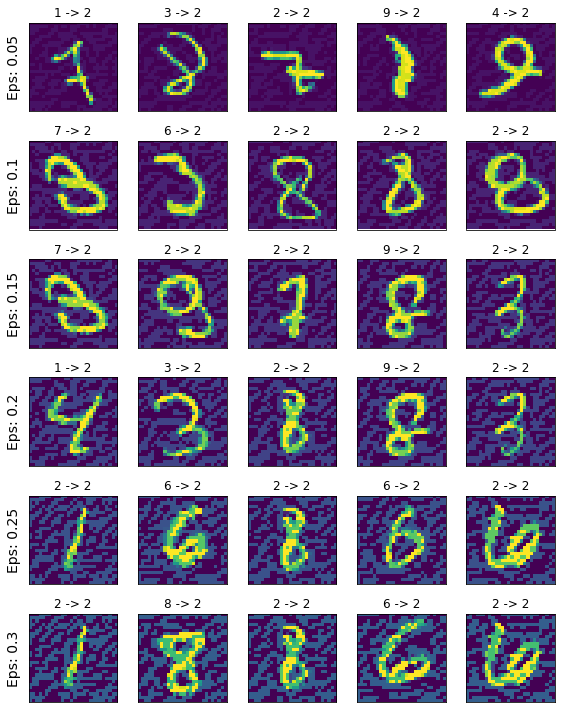

In [183]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(EPSILONS)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(EPSILONS),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(EPSILONS[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
#         normalized_ex = np.transpose( (ex - ex.min()) / (ex.max() - ex.min()) , (1, 2, 0))
        plt.imshow(ex)
plt.tight_layout()
plt.show()

Hybrid model

In [17]:
class NewHybridModel(nn.Module):
    """
    Head is inception, classifier is VIB
    """
    def __init__(self, base_model, vib_model, device):
        super(NewHybridModel, self).__init__()
        self.device = device
        self.base_model = base_model
        self.base_model.fc2 = torch.nn.Identity()
        self.vib_model = vib_model
        self.train_loss = []
        self.test_loss = []
        
    def freeze_base(self):
        # Freeze the weights of the inception_model
        for param in self.base_model.parameters():
            param.requires_grad = False

    def unfreeze_base(self):
        # Freeze the weights of the inception_model
        for param in self.base_model.parameters():
            param.requires_grad = True
            
    def forward(self, x):
        encoded = self.base_model(x)
        logits = self.vib_model(encoded)
        return logits

Constant beta training

In [185]:
LR = 1e-4
EPOCHS = 210
BETA = 1e-3
NUM_MINIBATCHES = 1

run_name = f"vib_mnist_const_beta_0001_512_time_{int(time.time())}"

constant_vib_mnist_classifier = VIB(256, device).to(device)
mnist_vib_hybrid_model = NewHybridModel(mnist_model, constant_vib_mnist_classifier, device)
mnist_vib_hybrid_model.freeze_base()

optimizer = optim.Adam(filter(lambda p: p.requires_grad, mnist_vib_hybrid_model.parameters()), LR / NUM_MINIBATCHES, betas=(0.5,0.999))
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.97)

loop_data(mnist_vib_hybrid_model, mnist_train_loader, mnist_test_loader, BETA,
          num_minibatches=NUM_MINIBATCHES, model_save_path='/tmp', epochs=EPOCHS, device=device,
          optimizer=optimizer, scheduler=scheduler, is_ppo=False, run_name=run_name)

wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`
100%|█████████████████████████████████████████| 210/210 [17:03<00:00,  4.87s/it]


In [ ]:
# 0.989

In [186]:
test_model(mnist_vib_hybrid_model, mnist_test_loader)

100%|██████████████████████████████████████████| 79/79 [00:00<00:00, 102.62it/s]

tensor(0.9914, device='cuda:0')
acc: None


Constant beta attack - untargeted

In [187]:
mnist_vib_hybrid_model.unfreeze_base()

In [188]:
accuracies = []
examples = []
total_succesful_attacks_list = []

# Run test for each epsilon
for eps in tqdm(EPSILONS):
    acc, total_succesful_attacks, ex = run_adverserial_attacks(mnist_vib_hybrid_model, device, mnist_test_loader, eps, is_image=True)#, target_label=805)
    accuracies.append(acc)
    total_succesful_attacks_list.append(total_succesful_attacks)    
    examples.append(ex)

 17%|███████▌                                     | 1/6 [00:00<00:03,  1.26it/s]

Epsilon: 0.05	Test Accuracy = 9700 / 9914 = 0.9784143567085266	 %succesful attacks: 0.02158563647367359	 Out of total of 10112 data points


 33%|███████████████                              | 2/6 [00:01<00:03,  1.26it/s]

Epsilon: 0.1	Test Accuracy = 9376 / 9914 = 0.9457333087921143	 %succesful attacks: 0.05426669356465604	 Out of total of 10112 data points


 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.26it/s]

Epsilon: 0.15	Test Accuracy = 8904 / 9914 = 0.8981238603591919	 %succesful attacks: 0.10187613475892678	 Out of total of 10112 data points


 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.26it/s]

Epsilon: 0.2	Test Accuracy = 8113 / 9914 = 0.8183376789093018	 %succesful attacks: 0.18166229574339318	 Out of total of 10112 data points


 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.27it/s]

Epsilon: 0.25	Test Accuracy = 6575 / 9914 = 0.6632035374641418	 %succesful attacks: 0.33679644946540244	 Out of total of 10112 data points


100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.26it/s]

Epsilon: 0.3	Test Accuracy = 4621 / 9914 = 0.4661085307598114	 %succesful attacks: 0.5338914666128707	 Out of total of 10112 data points


Constant beta attack - targeted

In [189]:
accuracies = []
examples = []
total_succesful_attacks_list = []

# Run test for each epsilon
for eps in tqdm(EPSILONS):
    acc, total_succesful_attacks, ex = run_adverserial_attacks(mnist_vib_hybrid_model, device, mnist_test_loader, eps, is_image=True, target_label=2)
    accuracies.append(acc)
    total_succesful_attacks_list.append(total_succesful_attacks)    
    examples.append(ex)

 17%|███████▌                                     | 1/6 [00:00<00:04,  1.24it/s]

Epsilon: 0.05	Test Accuracy = 8824 / 8956 = 0.9852612614631653	 %succesful attacks: 0.004131308619919607	 Out of total of 10112 data points


 33%|███████████████                              | 2/6 [00:01<00:03,  1.28it/s]

Epsilon: 0.1	Test Accuracy = 8652 / 8956 = 0.9660562872886658	 %succesful attacks: 0.011165698972755694	 Out of total of 10112 data points


 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.29it/s]

Epsilon: 0.15	Test Accuracy = 8287 / 8956 = 0.9253014922142029	 %succesful attacks: 0.022889682894149173	 Out of total of 10112 data points


 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.27it/s]

Epsilon: 0.2	Test Accuracy = 7571 / 8956 = 0.8453550934791565	 %succesful attacks: 0.047007592675301475	 Out of total of 10112 data points


 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.29it/s]

Epsilon: 0.25	Test Accuracy = 6280 / 8956 = 0.7012059092521667	 %succesful attacks: 0.10328271549799017	 Out of total of 10112 data points


100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.29it/s]

Epsilon: 0.3	Test Accuracy = 4733 / 8956 = 0.5284725427627563	 %succesful attacks: 0.177422956677088	 Out of total of 10112 data points


Dyn beta

In [190]:
LR = 1e-4
EPOCHS = 210
BETA = 1
NUM_MINIBATCHES = 4

run_name = f"vib_mnist_dyn_beta_1_time_{int(time.time())}"

dyn_vib_beta_1_mnist_classifier = VIB(256, device).to(device)
mnist_vib_hybrid_dyn_model = NewHybridModel(mnist_model, dyn_vib_beta_1_mnist_classifier, device)
mnist_vib_hybrid_dyn_model.freeze_base()

optimizer = optim.Adam(filter(lambda p: p.requires_grad, mnist_vib_hybrid_dyn_model.parameters()), LR / NUM_MINIBATCHES, betas=(0.5,0.999))
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.97)

loop_data(mnist_vib_hybrid_dyn_model, mnist_train_loader, mnist_test_loader, BETA,
          num_minibatches=NUM_MINIBATCHES, model_save_path='/tmp', epochs=EPOCHS, device=device,
          optimizer=optimizer, scheduler=scheduler, is_ppo=True, run_name=run_name)


charts/epoch_classification_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
charts/epoch_total_kld,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
charts/epoch_train_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
charts/epoch_val_loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
charts/epoch_classification_loss,0.00169
charts/epoch_total_kld,15.55872
charts/epoch_train_loss,0.01729
charts/epoch_val_loss,162.66594
global_step,196


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`
100%|█████████████████████████████████████████| 210/210 [27:43<00:00,  7.92s/it]


In [168]:
# 0.9891

In [191]:
test_model(mnist_vib_hybrid_dyn_model, mnist_test_loader)

100%|███████████████████████████████████████████| 79/79 [00:00<00:00, 97.11it/s]

tensor(0.9911, device='cuda:0')
acc: None


Dyn beta untargeted

In [192]:
mnist_vib_hybrid_dyn_model.unfreeze_base()

In [193]:
accuracies = []
examples = []
total_succesful_attacks_list = []

# Run test for each epsilon
for eps in tqdm(EPSILONS):
    acc, total_succesful_attacks, ex = run_adverserial_attacks(mnist_vib_hybrid_dyn_model, device, mnist_test_loader, eps, is_image=True)#, target_label=805)
    accuracies.append(acc)
    total_succesful_attacks_list.append(total_succesful_attacks)    
    examples.append(ex)

 17%|███████▌                                     | 1/6 [00:00<00:03,  1.27it/s]

Epsilon: 0.05	Test Accuracy = 9687 / 9911 = 0.9773988723754883	 %succesful attacks: 0.022601150237110283	 Out of total of 10112 data points


 33%|███████████████                              | 2/6 [00:01<00:03,  1.23it/s]

Epsilon: 0.1	Test Accuracy = 9195 / 9911 = 0.9277570247650146	 %succesful attacks: 0.07224296236504893	 Out of total of 10112 data points


 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.23it/s]

Epsilon: 0.15	Test Accuracy = 8338 / 9911 = 0.8412874341011047	 %succesful attacks: 0.15871254162042175	 Out of total of 10112 data points


 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.22it/s]

Epsilon: 0.2	Test Accuracy = 6952 / 9911 = 0.7014428377151489	 %succesful attacks: 0.2985571587125416	 Out of total of 10112 data points


 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.22it/s]

Epsilon: 0.25	Test Accuracy = 5167 / 9911 = 0.5213399529457092	 %succesful attacks: 0.47866007466451416	 Out of total of 10112 data points


100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.23it/s]

Epsilon: 0.3	Test Accuracy = 3538 / 9911 = 0.35697710514068604	 %succesful attacks: 0.6430229038442135	 Out of total of 10112 data points


Dyn beta targeted

In [194]:
accuracies = []
examples = []
total_succesful_attacks_list = []

# Run test for each epsilon
for eps in tqdm(EPSILONS):
    acc, total_succesful_attacks, ex = run_adverserial_attacks(mnist_vib_hybrid_dyn_model, device, mnist_test_loader, eps, is_image=True, target_label=2)
    accuracies.append(acc)
    total_succesful_attacks_list.append(total_succesful_attacks)    
    examples.append(ex)

 17%|███████▌                                     | 1/6 [00:00<00:04,  1.25it/s]

Epsilon: 0.05	Test Accuracy = 8832 / 8957 = 0.9860444068908691	 %succesful attacks: 0.0043541364296081275	 Out of total of 10112 data points


 33%|███████████████                              | 2/6 [00:01<00:03,  1.19it/s]

Epsilon: 0.1	Test Accuracy = 8662 / 8957 = 0.9670648574829102	 %succesful attacks: 0.0152952997655465	 Out of total of 10112 data points


 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.18it/s]

Epsilon: 0.15	Test Accuracy = 8331 / 8957 = 0.930110514163971	 %succesful attacks: 0.03427486881768449	 Out of total of 10112 data points


 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.17it/s]

Epsilon: 0.2	Test Accuracy = 7588 / 8957 = 0.847158670425415	 %succesful attacks: 0.0764764988277325	 Out of total of 10112 data points


 83%|█████████████████████████████████████▌       | 5/6 [00:04<00:00,  1.18it/s]

Epsilon: 0.25	Test Accuracy = 6265 / 8957 = 0.6994529366493225	 %succesful attacks: 0.15395779836998996	 Out of total of 10112 data points


100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.19it/s]

Epsilon: 0.3	Test Accuracy = 4803 / 8957 = 0.5362286567687988	 %succesful attacks: 0.2528748464887797	 Out of total of 10112 data points


#### Rebuilding for CIFAR

In [13]:
from torchvision.datasets import CIFAR100

Data

In [14]:
CIFAR_DATASET_DIR = '/D/datasets/CIFAR'
BATCH_SIZE = 128
NUM_WORKERS = 1

# Data augmentation and normalization for training
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Just normalization for testing
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

if os.path.isdir(CIFAR_DATASET_DIR):
    cifar_train_data = CIFAR100(root=CIFAR_DATASET_DIR, train=True, transform=train_transform)
    cifar_test_data = CIFAR100(root=CIFAR_DATASET_DIR, train=False, transform=test_transform)
else:
    os.mkdir(CIFAR_DATASET_DIR)
    cifar_train_data = CIFAR100(root=CIFAR_DATASET_DIR, train=True, download=True, transform=train_transform)
    cifar_test_data = CIFAR100(root=CIFAR_DATASET_DIR, train=False, download=True, transform=test_transform)

cifar_train_loader = DataLoader(cifar_train_data,
                      batch_size=BATCH_SIZE,
                      shuffle=True,
                      num_workers=NUM_WORKERS,
                      drop_last=True)

cifar_test_loader = DataLoader(cifar_test_data,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=NUM_WORKERS,
                         drop_last=False)

cifar_classes = cifar_train_data.classes

In [15]:
pretrained_cifar_model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar100_repvgg_a2", pretrained=True)
pretrained_cifar_model = pretrained_cifar_model.to(device)

Using cache found in /home/nir/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


In [215]:
test_model(pretrained_cifar_model, cifar_test_loader)

100%|███████████████████████████████████████████| 79/79 [00:03<00:00, 20.10it/s]

tensor(0.7186, device='cuda:0')
acc: None


In [23]:
LR = 1e-4
EPOCHS = 50
BETA = 3e-3
NUM_MINIBATCHES = 1

for beta in [1e-3, 1e-2, 1e-1, 0.5, 1]:
    run_name = f"cifar_new_loss_{beta}_time_{int(time.time())}"

    new_loss_vib_cifar_classifier = VIB(100, device).to(device)
    cifar_vib_hybrid_model = NewHybridModel(pretrained_cifar_model, new_loss_vib_cifar_classifier, device)
    cifar_vib_hybrid_model.freeze_base()

    optimizer = optim.Adam(filter(lambda p: p.requires_grad, cifar_vib_hybrid_model.parameters()), LR / NUM_MINIBATCHES, betas=(0.5,0.999))
    scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.97)

    loop_data(cifar_vib_hybrid_model, cifar_train_loader, cifar_test_loader, beta,
              num_minibatches=NUM_MINIBATCHES, model_save_path='/tmp', epochs=EPOCHS, device=device,
              optimizer=optimizer, scheduler=scheduler, is_ppo=False, run_name=run_name, is_new_loss=True)

    test_model(cifar_vib_hybrid_model, cifar_test_loader)
    

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nirzvi89 (reichman_uni). Use `wandb login --relogin` to force relogin


  0%|                                                    | 0/50 [00:00<?, ?it/s]


TypeError: maximum(): argument 'input' (position 1) must be Tensor, not float

In [24]:
%debug

> /tmp/ipykernel_180814/1369479572.py(14)get_multivariate_gaussian_entropy()
     12     D = std.shape[-1]
     13     log_term = torch.log(torch.clamp(torch.prod(std, dim=-1), min=epsilon))
---> 14     return torch.maximum(epsilon, ((D / 2) * (1 + np.log(2 * np.pi)) + 0.5 * log_term)).mean()
     15 
     16 

ipdb> ((D / 2) * (1 + np.log(2 * np.pi)) + 0.5 * log_term)
tensor([47.9211, 47.9211, 47.9211, 47.9211, 47.9211, 47.9211, 47.9211, 47.9211,
        47.9211, 47.9211, 47.9211, 47.9211, 47.9211, 47.9211, 47.9211, 47.9211,
        47.9211, 47.9211, 47.9211, 47.9211, 47.9211, 47.9211, 47.9211, 47.9211,
        47.9211, 47.9211, 47.9211, 47.9211, 47.9211, 47.9211, 47.9211, 47.9211,
        47.9211, 47.9211, 47.9211, 47.9211, 47.9211, 47.9211, 47.9211, 47.9211,
        47.9211, 47.9211, 47.9211, 47.9211, 47.9211, 47.9211, 47.9211, 47.9211,
        47.9211, 47.9211, 47.9211, 47.9211, 47.9211, 47.9211, 47.9211, 47.9211,
        47.9211, 47.9211, 47.9211, 47.9211, 47.9211, 47.9211, 47.921

Untargeted attack - original model

In [220]:
accuracies = []
examples = []
total_succesful_attacks_list = []

# Run test for each epsilon
for eps in tqdm(EPSILONS):
    acc, total_succesful_attacks, ex = run_adverserial_attacks(pretrained_cifar_model, device, cifar_test_loader, eps, is_image=True)#, target_label=805)
    accuracies.append(acc)
    total_succesful_attacks_list.append(total_succesful_attacks)    
    examples.append(ex)

 17%|███████▌                                     | 1/6 [00:15<01:17, 15.46s/it]

Epsilon: 0.05	Test Accuracy = 1705 / 7186 = 0.2372669130563736	 %succesful attacks: 0.7627330921235737	 Out of total of 10112 data points


 33%|███████████████                              | 2/6 [00:31<01:02, 15.52s/it]

Epsilon: 0.1	Test Accuracy = 1359 / 7186 = 0.18911772966384888	 %succesful attacks: 0.8108822710826608	 Out of total of 10112 data points


 50%|██████████████████████▌                      | 3/6 [00:46<00:46, 15.58s/it]

Epsilon: 0.15	Test Accuracy = 1130 / 7186 = 0.15725021064281464	 %succesful attacks: 0.8427497912607849	 Out of total of 10112 data points


 67%|██████████████████████████████               | 4/6 [01:02<00:31, 15.65s/it]

Epsilon: 0.2	Test Accuracy = 961 / 7186 = 0.13373225927352905	 %succesful attacks: 0.866267742833287	 Out of total of 10112 data points


 83%|█████████████████████████████████████▌       | 5/6 [01:18<00:15, 15.71s/it]

Epsilon: 0.25	Test Accuracy = 831 / 7186 = 0.1156415268778801	 %succesful attacks: 0.8843584748121347	 Out of total of 10112 data points


100%|█████████████████████████████████████████████| 6/6 [01:34<00:00, 15.69s/it]

Epsilon: 0.3	Test Accuracy = 737 / 7186 = 0.10256053507328033	 %succesful attacks: 0.8974394656276092	 Out of total of 10112 data points


Targeted attack - Original model

In [221]:
accuracies = []
examples = []
total_succesful_attacks_list = []

# Run test for each epsilon
for eps in tqdm(EPSILONS):
    acc, total_succesful_attacks, ex = run_adverserial_attacks(pretrained_cifar_model, device, cifar_test_loader, eps, is_image=True, target_label=15)
    accuracies.append(acc)
    total_succesful_attacks_list.append(total_succesful_attacks)    
    examples.append(ex)

 17%|███████▌                                     | 1/6 [00:16<01:22, 16.42s/it]

Epsilon: 0.05	Test Accuracy = 2381 / 9871 = 0.24121162295341492	 %succesful attacks: 0.004052274338972748	 Out of total of 10112 data points


 33%|███████████████                              | 2/6 [00:32<01:05, 16.50s/it]

Epsilon: 0.1	Test Accuracy = 2027 / 9871 = 0.20534899830818176	 %succesful attacks: 0.005369263499138892	 Out of total of 10112 data points


 50%|██████████████████████▌                      | 3/6 [00:49<00:49, 16.56s/it]

Epsilon: 0.15	Test Accuracy = 1737 / 9871 = 0.17597001791000366	 %succesful attacks: 0.004356194914395705	 Out of total of 10112 data points


 67%|██████████████████████████████               | 4/6 [01:06<00:33, 16.61s/it]

Epsilon: 0.2	Test Accuracy = 1535 / 9871 = 0.15550602972507477	 %succesful attacks: 0.00314051261270388	 Out of total of 10112 data points


 83%|█████████████████████████████████████▌       | 5/6 [01:23<00:16, 16.65s/it]

Epsilon: 0.25	Test Accuracy = 1352 / 9871 = 0.13696686923503876	 %succesful attacks: 0.002431364603383649	 Out of total of 10112 data points


100%|█████████████████████████████████████████████| 6/6 [01:39<00:00, 16.63s/it]

Epsilon: 0.3	Test Accuracy = 1212 / 9871 = 0.12278391420841217	 %succesful attacks: 0.0019248303110120555	 Out of total of 10112 data points


Constant beta training

In [228]:
LR = 1e-4
EPOCHS = 100
BETA = 3e-3
NUM_MINIBATCHES = 1

run_name = f"vib_cifar_const_beta_0003_512_time_{int(time.time())}"

constant_vib_cifar_classifier = VIB(100, device).to(device)
cifar_vib_hybrid_model = NewHybridModel(pretrained_cifar_model, constant_vib_cifar_classifier, device)
cifar_vib_hybrid_model.freeze_base()

optimizer = optim.Adam(filter(lambda p: p.requires_grad, cifar_vib_hybrid_model.parameters()), LR / NUM_MINIBATCHES, betas=(0.5,0.999))
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.97)

loop_data(cifar_vib_hybrid_model, cifar_train_loader, cifar_test_loader, BETA,
          num_minibatches=NUM_MINIBATCHES, model_save_path='/tmp', epochs=EPOCHS, device=device,
          optimizer=optimizer, scheduler=scheduler, is_ppo=False, run_name=run_name)

charts/epoch_classification_loss,█▃▂▁▁▁▁▁▁▁▁▁▁
charts/epoch_total_kld,▆█▇▅▄▄▃▂▂▂▁▁▁
charts/epoch_train_loss,█▃▂▂▂▁▁▁▁▁▁▁▁
charts/epoch_val_loss,██▆▅▄▃▃▂▂▂▁▁
global_step,▁▂▂▃▃▄▅▅▆▆▇▇█
charts/epoch_classification_loss,0.07863
charts/epoch_total_kld,95.67377
charts/epoch_train_loss,0.36659
charts/epoch_val_loss,3170.1084
global_step,12


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`
100%|███████████████████████████████████████| 100/100 [1:22:29<00:00, 49.50s/it]


In [229]:
test_model(cifar_vib_hybrid_model, cifar_test_loader)

100%|███████████████████████████████████████████| 79/79 [00:04<00:00, 17.60it/s]

tensor(0.7633, device='cuda:0')
acc: None


In [230]:
cifar_vib_hybrid_model.unfreeze_base()

Untargeted attack - const beta model

In [236]:
accuracies = []
examples = []
total_succesful_attacks_list = []

# Run test for each epsilon
for eps in tqdm(EPSILONS):
    acc, total_succesful_attacks, ex = run_adverserial_attacks(cifar_vib_hybrid_model, device, cifar_test_loader, eps, is_image=True)#, target_label=805)
    accuracies.append(acc)
    total_succesful_attacks_list.append(total_succesful_attacks)    
    examples.append(ex)

 17%|███████▌                                     | 1/6 [00:19<01:37, 19.54s/it]

Epsilon: 0.05	Test Accuracy = 1682 / 7633 = 0.2203589677810669	 %succesful attacks: 0.7796410323594917	 Out of total of 10112 data points


 33%|███████████████                              | 2/6 [00:39<01:18, 19.66s/it]

Epsilon: 0.1	Test Accuracy = 1334 / 7633 = 0.17476746439933777	 %succesful attacks: 0.8252325429058037	 Out of total of 10112 data points


 50%|██████████████████████▌                      | 3/6 [00:59<00:59, 19.78s/it]

Epsilon: 0.15	Test Accuracy = 1117 / 7633 = 0.14633826911449432	 %succesful attacks: 0.8536617319533604	 Out of total of 10112 data points


 67%|██████████████████████████████               | 4/6 [01:19<00:39, 19.88s/it]

Epsilon: 0.2	Test Accuracy = 972 / 7633 = 0.12734180688858032	 %succesful attacks: 0.8726581946809905	 Out of total of 10112 data points


 83%|█████████████████████████████████████▌       | 5/6 [01:39<00:19, 19.98s/it]

Epsilon: 0.25	Test Accuracy = 837 / 7633 = 0.10965543985366821	 %succesful attacks: 0.8903445565308529	 Out of total of 10112 data points


100%|█████████████████████████████████████████████| 6/6 [01:59<00:00, 19.94s/it]

Epsilon: 0.3	Test Accuracy = 734 / 7633 = 0.09616140276193619	 %succesful attacks: 0.9038385955718591	 Out of total of 10112 data points


Targeted attack - const beta model

In [237]:
accuracies = []
examples = []
total_succesful_attacks_list = []

# Run test for each epsilon
for eps in tqdm(EPSILONS):
    acc, total_succesful_attacks, ex = run_adverserial_attacks(cifar_vib_hybrid_model, device, cifar_test_loader, eps, is_image=True, target_label=15)
    accuracies.append(acc)
    total_succesful_attacks_list.append(total_succesful_attacks)    
    examples.append(ex)

 17%|███████▌                                     | 1/6 [00:21<01:45, 21.02s/it]

Epsilon: 0.05	Test Accuracy = 2161 / 9866 = 0.2190350741147995	 %succesful attacks: 0.003142104196229475	 Out of total of 10112 data points


 33%|███████████████                              | 2/6 [00:42<01:24, 21.19s/it]

Epsilon: 0.1	Test Accuracy = 1798 / 9866 = 0.18224205076694489	 %succesful attacks: 0.003142104196229475	 Out of total of 10112 data points


 50%|██████████████████████▌                      | 3/6 [01:04<01:04, 21.43s/it]

Epsilon: 0.15	Test Accuracy = 1574 / 9866 = 0.15953780710697174	 %succesful attacks: 0.002432596797080884	 Out of total of 10112 data points


 67%|██████████████████████████████               | 4/6 [01:25<00:43, 21.56s/it]

Epsilon: 0.2	Test Accuracy = 1379 / 9866 = 0.1397729516029358	 %succesful attacks: 0.0018244475978106628	 Out of total of 10112 data points


 83%|█████████████████████████████████████▌       | 5/6 [01:47<00:21, 21.70s/it]

Epsilon: 0.25	Test Accuracy = 1215 / 9866 = 0.12315021455287933	 %succesful attacks: 0.0011149401986620718	 Out of total of 10112 data points


100%|█████████████████████████████████████████████| 6/6 [02:09<00:00, 21.63s/it]

Epsilon: 0.3	Test Accuracy = 1069 / 9866 = 0.10835191607475281	 %succesful attacks: 0.0008108655990269613	 Out of total of 10112 data points


Dyn beta hybrid model

In [28]:
LR = 1e-4
EPOCHS = 100
BETA = 1
NUM_MINIBATCHES = 4

run_name = f"vib_cifar_dyn_beta_new_kld_from_base_time_{int(time.time())}"

dyn_vib_cifar_classifier = VIB(100, device).to(device)
dyn_cifar_vib_hybrid_model = NewHybridModel(pretrained_cifar_model, dyn_vib_cifar_classifier, device)
dyn_cifar_vib_hybrid_model.freeze_base()

optimizer = optim.Adam(filter(lambda p: p.requires_grad, dyn_cifar_vib_hybrid_model.parameters()), LR / NUM_MINIBATCHES, betas=(0.5,0.999))
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.97)

loop_data(dyn_cifar_vib_hybrid_model, cifar_train_loader, cifar_test_loader, BETA,
          num_minibatches=NUM_MINIBATCHES, model_save_path='/tmp', epochs=EPOCHS, device=device,
          optimizer=optimizer, scheduler=scheduler, is_ppo=True, run_name=run_name)

wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`
100%|██████████████████████████████████████| 100/100 [3:15:23<00:00, 117.23s/it]


In [29]:
# newest kld ratio sum of old and new
test_model(dyn_cifar_vib_hybrid_model, cifar_test_loader)

100%|███████████████████████████████████████████| 79/79 [00:04<00:00, 17.45it/s]

tensor(0.7581, device='cuda:0')
acc: None


In [20]:
# reverse kld in ratio
test_model(dyn_cifar_vib_hybrid_model, cifar_test_loader)

100%|███████████████████████████████████████████| 79/79 [00:03<00:00, 20.01it/s]

tensor(0.7587, device='cuda:0')
acc: None


In [242]:
# old kld in ratio
test_model(dyn_cifar_vib_hybrid_model, cifar_test_loader)

100%|███████████████████████████████████████████| 79/79 [00:03<00:00, 19.93it/s]

tensor(0.7588, device='cuda:0')
acc: None


In [ ]:
dyn_cifar_vib_hybrid_model.unfreeze_base()

Untargeted attack - const beta model

In [243]:
accuracies = []
examples = []
total_succesful_attacks_list = []

# Run test for each epsilon
for eps in tqdm(EPSILONS):
    acc, total_succesful_attacks, ex = run_adverserial_attacks(dyn_cifar_vib_hybrid_model, device, cifar_test_loader, eps, is_image=True)#, target_label=805)
    accuracies.append(acc)
    total_succesful_attacks_list.append(total_succesful_attacks)    
    examples.append(ex)

 17%|███████▌                                     | 1/6 [00:19<01:36, 19.40s/it]

Epsilon: 0.05	Test Accuracy = 1728 / 7588 = 0.2277279943227768	 %succesful attacks: 0.77227200843437	 Out of total of 10112 data points


 33%|███████████████                              | 2/6 [00:38<01:17, 19.46s/it]

Epsilon: 0.1	Test Accuracy = 1363 / 7588 = 0.1796257197856903	 %succesful attacks: 0.8203742751713231	 Out of total of 10112 data points


 50%|██████████████████████▌                      | 3/6 [00:58<00:58, 19.54s/it]

Epsilon: 0.15	Test Accuracy = 1119 / 7588 = 0.1474696844816208	 %succesful attacks: 0.8525303110173958	 Out of total of 10112 data points


 67%|██████████████████████████████               | 4/6 [01:18<00:39, 19.63s/it]

Epsilon: 0.2	Test Accuracy = 960 / 7588 = 0.12651555240154266	 %succesful attacks: 0.8734844491302056	 Out of total of 10112 data points


 83%|█████████████████████████████████████▌       | 5/6 [01:38<00:19, 19.70s/it]

Epsilon: 0.25	Test Accuracy = 836 / 7588 = 0.11017395555973053	 %succesful attacks: 0.889826041117554	 Out of total of 10112 data points


100%|█████████████████████████████████████████████| 6/6 [01:58<00:00, 19.68s/it]

Epsilon: 0.3	Test Accuracy = 744 / 7588 = 0.09804955124855042	 %succesful attacks: 0.9019504480759093	 Out of total of 10112 data points


Targeted attack - const beta model

In [244]:
accuracies = []
examples = []
total_succesful_attacks_list = []

# Run test for each epsilon
for eps in tqdm(EPSILONS):
    acc, total_succesful_attacks, ex = run_adverserial_attacks(dyn_cifar_vib_hybrid_model, device, cifar_test_loader, eps, is_image=True, target_label=15)
    accuracies.append(acc)
    total_succesful_attacks_list.append(total_succesful_attacks)    
    examples.append(ex)

 17%|███████▌                                     | 1/6 [00:20<01:42, 20.50s/it]

Epsilon: 0.05	Test Accuracy = 2099 / 9872 = 0.2126215547323227	 %succesful attacks: 0.0023298217179902755	 Out of total of 10112 data points


 33%|███████████████                              | 2/6 [00:41<01:22, 20.54s/it]

Epsilon: 0.1	Test Accuracy = 1689 / 9872 = 0.17108994722366333	 %succesful attacks: 0.0019246353322528362	 Out of total of 10112 data points


 50%|██████████████████████▌                      | 3/6 [01:01<01:01, 20.58s/it]

Epsilon: 0.15	Test Accuracy = 1452 / 9872 = 0.14708265662193298	 %succesful attacks: 0.0014181523500810373	 Out of total of 10112 data points


 67%|██████████████████████████████               | 4/6 [01:22<00:41, 20.62s/it]

Epsilon: 0.2	Test Accuracy = 1258 / 9872 = 0.12743112444877625	 %succesful attacks: 0.0007090761750405186	 Out of total of 10112 data points


 83%|█████████████████████████████████████▌       | 5/6 [01:43<00:20, 20.67s/it]

Epsilon: 0.25	Test Accuracy = 1115 / 9872 = 0.11294570565223694	 %succesful attacks: 0.0002025931928687196	 Out of total of 10112 data points


100%|█████████████████████████████████████████████| 6/6 [02:03<00:00, 20.65s/it]

Epsilon: 0.3	Test Accuracy = 998 / 9872 = 0.10109400004148483	 %succesful attacks: 0.00030388978930307944	 Out of total of 10112 data points


In [32]:
EPSILONS = [.05, .1, .15, .2, .25, .3]

In [36]:
accuracies = []
examples = []
total_succesful_attacks_list = []

# Run test for each epsilon
for eps in tqdm(EPSILONS):
    acc, total_succesful_attacks, ex = run_adverserial_attacks(dyn_cifar_vib_hybrid_model, device, cifar_test_loader, eps, is_image=True)#, target_label=805)
    accuracies.append(acc)
    total_succesful_attacks_list.append(total_succesful_attacks)    
    examples.append(ex)

 17%|███████▌                                     | 1/6 [00:14<01:14, 14.86s/it]

Epsilon: 0.05	Test Accuracy = 1655 / 7581 = 0.2183089256286621	 %succesful attacks: 0.7816910697797125	 Out of total of 10112 data points


 33%|███████████████                              | 2/6 [00:29<00:59, 14.89s/it]

Epsilon: 0.1	Test Accuracy = 1315 / 7581 = 0.1734599620103836	 %succesful attacks: 0.826540034296267	 Out of total of 10112 data points


 50%|██████████████████████▌                      | 3/6 [00:44<00:44, 14.94s/it]

Epsilon: 0.15	Test Accuracy = 1097 / 7581 = 0.14470386505126953	 %succesful attacks: 0.8552961350745284	 Out of total of 10112 data points


 67%|██████████████████████████████               | 4/6 [00:59<00:29, 14.98s/it]

Epsilon: 0.2	Test Accuracy = 932 / 7581 = 0.12293892353773117	 %succesful attacks: 0.8770610737369741	 Out of total of 10112 data points


 83%|█████████████████████████████████████▌       | 5/6 [01:14<00:15, 15.04s/it]

Epsilon: 0.25	Test Accuracy = 820 / 7581 = 0.10816515237092972	 %succesful attacks: 0.8918348502836038	 Out of total of 10112 data points


100%|█████████████████████████████████████████████| 6/6 [01:30<00:00, 15.02s/it]

Epsilon: 0.3	Test Accuracy = 727 / 7581 = 0.09589763730764389	 %succesful attacks: 0.9041023611660731	 Out of total of 10112 data points


In [37]:
accuracies = []
examples = []
total_succesful_attacks_list = []

# Run test for each epsilon
for eps in tqdm(EPSILONS):
    acc, total_succesful_attacks, ex = run_adverserial_attacks(dyn_cifar_vib_hybrid_model, device, cifar_test_loader, eps, is_image=True, target_label=15)
    accuracies.append(acc)
    total_succesful_attacks_list.append(total_succesful_attacks)    
    examples.append(ex)

 17%|███████▌                                     | 1/6 [00:15<01:18, 15.73s/it]

Epsilon: 0.05	Test Accuracy = 1935 / 9875 = 0.19594936072826385	 %succesful attacks: 0.0014177215189873419	 Out of total of 10112 data points


 33%|███████████████                              | 2/6 [00:31<01:03, 15.75s/it]

Epsilon: 0.1	Test Accuracy = 1602 / 9875 = 0.16222785413265228	 %succesful attacks: 0.0014177215189873419	 Out of total of 10112 data points


 50%|██████████████████████▌                      | 3/6 [00:47<00:47, 15.77s/it]

Epsilon: 0.15	Test Accuracy = 1364 / 9875 = 0.13812658190727234	 %succesful attacks: 0.0007088607594936709	 Out of total of 10112 data points


 67%|██████████████████████████████               | 4/6 [01:03<00:31, 15.80s/it]

Epsilon: 0.2	Test Accuracy = 1190 / 9875 = 0.12050633132457733	 %succesful attacks: 0.00020253164556962027	 Out of total of 10112 data points


 83%|█████████████████████████████████████▌       | 5/6 [01:19<00:15, 15.83s/it]

Epsilon: 0.25	Test Accuracy = 1026 / 9875 = 0.10389873385429382	 %succesful attacks: 0.00040506329113924053	 Out of total of 10112 data points


100%|█████████████████████████████████████████████| 6/6 [01:34<00:00, 15.82s/it]

Epsilon: 0.3	Test Accuracy = 903 / 9875 = 0.09144303947687149	 %succesful attacks: 0.00020253164556962027	 Out of total of 10112 data points


Beta is 0

In [38]:
LR = 1e-4
EPOCHS = 100
BETA = 0
NUM_MINIBATCHES = 4

run_name = f"zero_beta_{int(time.time())}"

zero_beta_cifar_classifier = VIB(100, device).to(device)
zero_beta_hybrid_model = NewHybridModel(pretrained_cifar_model, zero_beta_cifar_classifier, device)
zero_beta_hybrid_model.freeze_base()

optimizer = optim.Adam(filter(lambda p: p.requires_grad, zero_beta_hybrid_model.parameters()), LR / NUM_MINIBATCHES, betas=(0.5,0.999))
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.97)

loop_data(zero_beta_hybrid_model, cifar_train_loader, cifar_test_loader, BETA,
          num_minibatches=NUM_MINIBATCHES, model_save_path='/tmp', epochs=EPOCHS, device=device,
          optimizer=optimizer, scheduler=scheduler, is_ppo=True, run_name=run_name)

charts/avg_epoch_ratio,█▂▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
charts/epoch_classification_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
charts/epoch_kld_from_base_new,█▃▁▁▃▁▁█▁▁▁▁▁▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
charts/epoch_kld_from_base_old,█▃▁▁▃▁▁█▁▁▁▁▁▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
charts/epoch_ratio1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
charts/epoch_ratio2,█▂▁▁▂▁▁▃▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁
charts/epoch_ratio3,█▂▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
charts/epoch_ratio4,█▂▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
charts/epoch_total_kld,▂▆▇██▆▇▆▆▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
charts/epoch_train_loss,█▃▁▁▂▁▁▃▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
charts/epoch_val_loss,▃▇▇██▆▇▅▅▆▄▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`
100%|██████████████████████████████████████| 100/100 [3:15:06<00:00, 117.07s/it]


In [39]:
test_model(zero_beta_hybrid_model, cifar_test_loader)

100%|███████████████████████████████████████████| 79/79 [00:04<00:00, 16.88it/s]

tensor(0.7643, device='cuda:0')
acc: None


In [41]:
accuracies = []
examples = []
total_succesful_attacks_list = []

# Run test for each epsilon
for eps in tqdm(EPSILONS):
    acc, total_succesful_attacks, ex = run_adverserial_attacks(zero_beta_hybrid_model, device, cifar_test_loader, eps, is_image=True)#, target_label=805)
    accuracies.append(acc)
    total_succesful_attacks_list.append(total_succesful_attacks)    
    examples.append(ex)

 17%|███████▌                                     | 1/6 [00:14<01:14, 14.86s/it]

Epsilon: 0.05	Test Accuracy = 1573 / 7643 = 0.20580923557281494	 %succesful attacks: 0.7941907627894805	 Out of total of 10112 data points


 33%|███████████████                              | 2/6 [00:29<00:59, 14.92s/it]

Epsilon: 0.1	Test Accuracy = 1240 / 7643 = 0.1622399538755417	 %succesful attacks: 0.8377600418683763	 Out of total of 10112 data points


 50%|██████████████████████▌                      | 3/6 [00:44<00:44, 14.96s/it]

Epsilon: 0.15	Test Accuracy = 1034 / 7643 = 0.13528719544410706	 %succesful attacks: 0.8647128091063718	 Out of total of 10112 data points


 67%|██████████████████████████████               | 4/6 [00:59<00:30, 15.01s/it]

Epsilon: 0.2	Test Accuracy = 878 / 7643 = 0.11487635970115662	 %succesful attacks: 0.8851236425487374	 Out of total of 10112 data points


 83%|█████████████████████████████████████▌       | 5/6 [01:15<00:15, 15.06s/it]

Epsilon: 0.25	Test Accuracy = 760 / 7643 = 0.09943739324808121	 %succesful attacks: 0.9005626063064242	 Out of total of 10112 data points


100%|█████████████████████████████████████████████| 6/6 [01:30<00:00, 15.05s/it]

Epsilon: 0.3	Test Accuracy = 674 / 7643 = 0.08818526566028595	 %succesful attacks: 0.9118147324349077	 Out of total of 10112 data points


In [42]:
accuracies = []
examples = []
total_succesful_attacks_list = []

# Run test for each epsilon
for eps in tqdm(EPSILONS):
    acc, total_succesful_attacks, ex = run_adverserial_attacks(zero_beta_hybrid_model, device, cifar_test_loader, eps, is_image=True, target_label=15)
    accuracies.append(acc)
    total_succesful_attacks_list.append(total_succesful_attacks)    
    examples.append(ex)

 17%|███████▌                                     | 1/6 [00:15<01:18, 15.74s/it]

Epsilon: 0.05	Test Accuracy = 1913 / 9880 = 0.19362348318099976	 %succesful attacks: 0.0018218623481781376	 Out of total of 10112 data points


 33%|███████████████                              | 2/6 [00:31<01:03, 15.76s/it]

Epsilon: 0.1	Test Accuracy = 1615 / 9880 = 0.16346153616905212	 %succesful attacks: 0.0016194331983805667	 Out of total of 10112 data points


 50%|██████████████████████▌                      | 3/6 [00:47<00:47, 15.78s/it]

Epsilon: 0.15	Test Accuracy = 1348 / 9880 = 0.13643725216388702	 %succesful attacks: 0.0013157894736842105	 Out of total of 10112 data points


 67%|██████████████████████████████               | 4/6 [01:03<00:31, 15.81s/it]

Epsilon: 0.2	Test Accuracy = 1150 / 9880 = 0.11639676243066788	 %succesful attacks: 0.0005060728744939271	 Out of total of 10112 data points


 83%|█████████████████████████████████████▌       | 5/6 [01:19<00:15, 15.84s/it]

Epsilon: 0.25	Test Accuracy = 1008 / 9880 = 0.10202429443597794	 %succesful attacks: 0.0006072874493927126	 Out of total of 10112 data points


100%|█████████████████████████████████████████████| 6/6 [01:35<00:00, 15.84s/it]

Epsilon: 0.3	Test Accuracy = 885 / 9880 = 0.08957489579916	 %succesful attacks: 0.0004048582995951417	 Out of total of 10112 data points


In [538]:
LR = 1e-4
EPOCHS = 100
BETA = 1
NUM_MINIBATCHES = 1

run_name = f"test_new_entropy_{int(time.time())}"

test_cifar_classifier = VIB(100, device).to(device)
test_hybrid_model = NewHybridModel(pretrained_cifar_model, test_cifar_classifier, device)
test_hybrid_model.freeze_base()

optimizer = optim.Adam(filter(lambda p: p.requires_grad, test_hybrid_model.parameters()), LR / NUM_MINIBATCHES, betas=(0.5,0.999))
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.97)

loop_data(test_hybrid_model, cifar_train_loader, cifar_test_loader, BETA,
          num_minibatches=NUM_MINIBATCHES, model_save_path='/tmp', epochs=EPOCHS, device=device,
          optimizer=optimizer, scheduler=scheduler, is_ppo=False, run_name=run_name, is_dyn_beta=True)


charts/epoch_classification_loss,▇▁▅█▇▇▆▅▄▃▂▂▂▁▁
charts/epoch_dyn_beta,▁▁█▂▂▂▂▂▂▂▁▁▁▁▁▁
charts/epoch_i_z_x,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
charts/epoch_i_z_y,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
charts/epoch_total_kld,▄█▂▁▁▁▁▁▁▁▁▁▁▁▁
charts/epoch_train_loss,▁▁█▂▁▁▁▁▁▁▁▁▁▁▁
charts/epoch_val_loss,▁▁█▂▂▂▂▂▂▂▁▁▁▁▁
global_step,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
charts/epoch_classification_loss,0.74194
charts/epoch_dyn_beta,0.03847
charts/epoch_i_z_x,0.0


wandb: WARNING When using several event log directories, please call `wandb.tensorboard.patch(root_logdir="...")` before `wandb.init`
100%|███████████████████████████████████████| 100/100 [1:22:07<00:00, 49.28s/it]


In [539]:
test_model(test_hybrid_model, cifar_test_loader)

100%|███████████████████████████████████████████| 79/79 [00:03<00:00, 20.02it/s]

tensor(0.7627, device='cuda:0')
acc: None


In [540]:
accuracies = []
examples = []
total_succesful_attacks_list = []

# Run test for each epsilon
for eps in tqdm(EPSILONS):
    acc, total_succesful_attacks, ex = run_adverserial_attacks(test_hybrid_model, device, cifar_test_loader, eps, is_image=True)#, target_label=805)
    accuracies.append(acc)
    total_succesful_attacks_list.append(total_succesful_attacks)    
    examples.append(ex)

 17%|███████▌                                     | 1/6 [00:14<01:14, 14.84s/it]

Epsilon: 0.05	Test Accuracy = 1678 / 7627 = 0.22000786662101746	 %succesful attacks: 0.7799921332109611	 Out of total of 10112 data points


 33%|███████████████                              | 2/6 [00:29<00:59, 14.87s/it]

Epsilon: 0.1	Test Accuracy = 1339 / 7627 = 0.17556050419807434	 %succesful attacks: 0.8244394912809755	 Out of total of 10112 data points


 50%|██████████████████████▌                      | 3/6 [00:44<00:44, 14.92s/it]

Epsilon: 0.15	Test Accuracy = 1094 / 7627 = 0.14343778789043427	 %succesful attacks: 0.8565622131899829	 Out of total of 10112 data points


 67%|██████████████████████████████               | 4/6 [00:59<00:29, 14.97s/it]

Epsilon: 0.2	Test Accuracy = 943 / 7627 = 0.12363970279693604	 %succesful attacks: 0.8763602989379835	 Out of total of 10112 data points


 83%|█████████████████████████████████████▌       | 5/6 [01:14<00:15, 15.02s/it]

Epsilon: 0.25	Test Accuracy = 804 / 7627 = 0.1054149717092514	 %succesful attacks: 0.8945850268781959	 Out of total of 10112 data points


100%|█████████████████████████████████████████████| 6/6 [01:30<00:00, 15.00s/it]

Epsilon: 0.3	Test Accuracy = 710 / 7627 = 0.09309034049510956	 %succesful attacks: 0.9069096630392028	 Out of total of 10112 data points


In [541]:
accuracies = []
examples = []
total_succesful_attacks_list = []

# Run test for each epsilon
for eps in tqdm(EPSILONS):
    acc, total_succesful_attacks, ex = run_adverserial_attacks(test_hybrid_model, device, cifar_test_loader, eps, is_image=True, target_label=15)
    accuracies.append(acc)
    total_succesful_attacks_list.append(total_succesful_attacks)    
    examples.append(ex)

 17%|███████▌                                     | 1/6 [00:15<01:18, 15.72s/it]

Epsilon: 0.05	Test Accuracy = 2159 / 9878 = 0.21856650710105896	 %succesful attacks: 0.0024296416278598906	 Out of total of 10112 data points


 33%|███████████████                              | 2/6 [00:31<01:02, 15.75s/it]

Epsilon: 0.1	Test Accuracy = 1852 / 9878 = 0.18748734891414642	 %succesful attacks: 0.0024296416278598906	 Out of total of 10112 data points


 50%|██████████████████████▌                      | 3/6 [00:47<00:47, 15.77s/it]

Epsilon: 0.15	Test Accuracy = 1530 / 9878 = 0.15488965809345245	 %succesful attacks: 0.0021259364243774045	 Out of total of 10112 data points


 67%|██████████████████████████████               | 4/6 [01:03<00:31, 15.80s/it]

Epsilon: 0.2	Test Accuracy = 1311 / 9878 = 0.13271917402744293	 %succesful attacks: 0.0014172909495849362	 Out of total of 10112 data points


 83%|█████████████████████████████████████▌       | 5/6 [01:19<00:15, 15.83s/it]

Epsilon: 0.25	Test Accuracy = 1125 / 9878 = 0.11388944834470749	 %succesful attacks: 0.000911115610447459	 Out of total of 10112 data points


100%|█████████████████████████████████████████████| 6/6 [01:34<00:00, 15.82s/it]

Epsilon: 0.3	Test Accuracy = 998 / 9878 = 0.10103259980678558	 %succesful attacks: 0.00020247013565499088	 Out of total of 10112 data points
